##Biocliq Placement Challenge

**Akshath SB PES2UG20CS031**

I have performed all the computation on colab itself

The first part of the notebook contains the training,testing and inference.

If you want to test this model on a test set you can skip to the **Running Custom Test Data** part.

## Necessary Installations

I am using in this notebook and MONAI which is a pytorch based framework for deep learning in healthcare imaging

In [19]:
!pip install torch

In [20]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00


In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Dataset

The dataset provided was uploaded to my drive with the name file.zip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


extracting the zip file to /datalab

In [6]:
from zipfile import ZipFile

file_name = "/content/drive/MyDrive/file.zip"
extracted_folder_path = "/datalab"


# Extracting the contents of the zip file
with ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f"Contents of '{file_name}' have been successfully extracted to '{extracted_folder_path}'.")



Contents of '/content/drive/MyDrive/file.zip' have been successfully extracted to '/datalab'.


Checking if the files are present





In [7]:
import os

# Replace these paths with the actual paths to your subfolders
subfolder1_path = '/datalab/imagesTr'
subfolder2_path = '/datalab/labelsTr'

# List the contents of the first subfolder
contents_subfolder1 = os.listdir(subfolder1_path)
print("Contents of Subfolder 1:", contents_subfolder1)

# List the contents of the second subfolder
contents_subfolder2 = os.listdir(subfolder2_path)
print("Contents of Subfolder 2:", contents_subfolder2)

Contents of Subfolder 1: ['1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686_0000.nii.gz', '1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517_0000.nii.gz', '1.3.6.1.4.1.1

Checking the dimensions of the image

In [8]:

import nibabel as nib
import os

# Path to the first NIfTI file in Subfolder 1
nifti_file_path = os.path.join(subfolder1_path, contents_subfolder1[1])

# Load the NIfTI file
nifti_img = nib.load(nifti_file_path)

# Access the image data and header
data = nifti_img.get_fdata()
header = nifti_img.header

print("Shape of the image data:", data.shape)

Shape of the image data: (512, 512, 141)


In [ ]:
PATH='/datalab'

In [9]:
import matplotlib.pyplot as plt

# Display a slice of the 3D image data
plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
plt.title('Slice of NIfTI Image')
plt.show()

Applying the original mask to the image

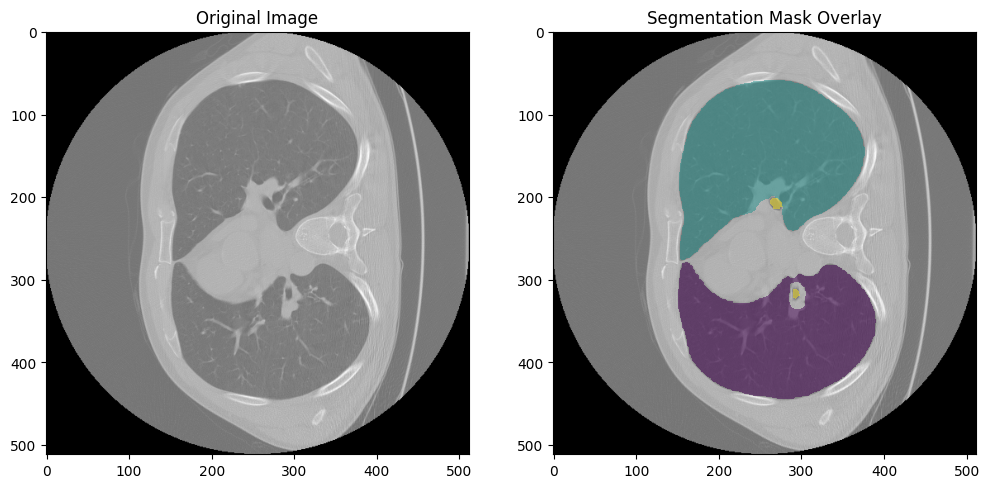

In [10]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Replace these paths with the actual paths to your image and segmentation mask files
image_file_path = '/datalab/imagesTr/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_0000.nii.gz'
mask_file_path = '/datalab/labelsTr/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.nii.gz'

# Load the image and mask
image_nifti = nib.load(image_file_path)
mask_nifti = nib.load(mask_file_path)

# Get image and mask data
image_data = image_nifti.get_fdata()
mask_data = mask_nifti.get_fdata()

# Display a slice of the original image and overlay the segmentation mask
slice_index = image_data.shape[2] // 2  # Choose a slice index for display

plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_data[:, :, slice_index], cmap='gray')
plt.title('Original Image')

# Display the segmentation mask overlay
plt.subplot(1, 2, 2)
plt.imshow(image_data[:, :, slice_index], cmap='gray')
plt.imshow(np.ma.masked_where(mask_data[:, :, slice_index] == 0, mask_data[:, :, slice_index]), cmap='viridis', alpha=0.5)
plt.title('Segmentation Mask Overlay')

plt.show()


As we see in the above image, the left lung , right lung and the trachea are displayed.

Lets remove the trachea label and amalgamate the left and right lung

In [12]:
import nibabel as nib
import numpy as np

def process_nifti(input_path, output_path):

    nifti_img = nib.load(input_path)
    data = nifti_img.get_fdata()

    # Eliminate trachea label
    data[data == trachea_label] = 0

    # Amalgamate left and right lung labels
    data[data == left_lung_label] = lung_label
    data[data == right_lung_label] = lung_label

    # Save the processed data to a new NIfTI file
    processed_nifti = nib.Nifti1Image(data, nifti_img.affine)
    nib.save(processed_nifti, output_path)

# Define label values
trachea_label = 5
left_lung_label = 3
right_lung_label = 4
lung_label = 6  # New label for amalgamated lungs



In [13]:
def process_all_nifti(input_folder, output_folder):

    for filename in os.listdir(input_folder):
        if filename.endswith(".nii.gz"):
            input_path = os.path.join(input_folder, filename)

            # Append "_processed.nii.gz" to the output filename
            output_filename = os.path.splitext(filename)[0][:-4] + "_processed.nii.gz"
            output_path = os.path.join(output_folder, output_filename)

            # Process the NIfTI file
            process_nifti(input_path, output_path)

# Specify input and output folder paths
input_folder_path = '/datalab/labelsTr'
output_folder_path = '/tmp'

# Process all NIfTI files in the input folder
process_all_nifti(input_folder_path, output_folder_path)

After performing the amalgamation, the label files are saved in /tmp

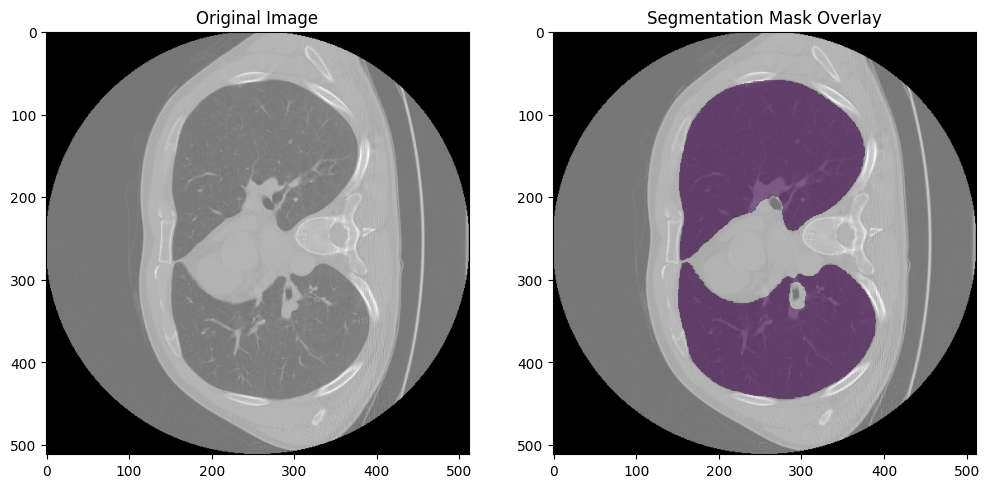

In [14]:
image_file_path = '/datalab/imagesTr/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_0000.nii.gz'
mask_file_path = '/tmp/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_processed.nii.gz'

# Load the image and mask
image_nifti = nib.load(image_file_path)
mask_nifti = nib.load(mask_file_path)

# Get image and mask data
image_data = image_nifti.get_fdata()
mask_data = mask_nifti.get_fdata()

# Display a slice of the original image and overlay the segmentation mask
slice_index = image_data.shape[2] // 2  # Choose a slice index for display

plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_data[:, :, slice_index], cmap='gray')
plt.title('Original Image')

# Display the segmentation mask overlay
plt.subplot(1, 2, 2)
plt.imshow(image_data[:, :, slice_index], cmap='gray')
plt.imshow(np.ma.masked_where(mask_data[:, :, slice_index] == 0, mask_data[:, :, slice_index]), cmap='viridis', alpha=0.5)
plt.title('Segmentation Mask Overlay')

plt.show()

We see in the above image that there is only segmentation for the entire lung

We see in the code below that the old labels has 4 classes

The new label now has only 2 classes.Background and Foreground(lung).


In [43]:
nifti_img = nib.load('/datalab/labelsTr/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.nii.gz')
data = nifti_img.get_fdata()
print(np.unique(data))

[0. 3. 4. 5.]


In [44]:
nifti_img = nib.load('/tmp/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260_processed.nii.gz')
data = nifti_img.get_fdata()
print(np.unique(data))

[0. 6.]


Checking to see if all the labels have lung mask

In [15]:
def find_empty(in_dir):
    '''
    This function will help you to find the empty volumes that you may not need for your training
    so instead of opening all the files and search for the empty ones, them use this function to make it quick.
    '''

    list_patients = []
    for patient in glob(os.path.join(in_dir, '*')):
        img = nib.load(patient)

        if len(np.unique(img.get_fdata())) < 2:
            print(os.path.basename(os.path.normpath(patient)))
            list_patients.append(os.path.basename(os.path.normpath(patient)))

    return list_patients

In [16]:
find_empty('/datalab/labelsTr')

[]

In [21]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

---

##Data Preprocessing

In the prepare function I perform data preprocessing

I split the data into training, validation and test sets.

32 - Training ,
8 - Validation ,
5 - Testing

In [22]:
import os
import shutil
from sklearn.model_selection import train_test_split

def prepare(in_dir, label_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=False):
    set_determinism(seed=0)

    # Load image and label paths
    path_images = sorted(glob(os.path.join(in_dir, "imagesTr", "*.nii.gz")))
    path_labels = sorted(glob(os.path.join(label_dir, "*.nii.gz")))

    # Split data into train, test, and validation sets
    train_images, test_images, train_labels, test_labels = train_test_split(
        path_images, path_labels, test_size=0.1, random_state=42
    )

    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=0.2, random_state=42
    )

    # Organize file paths into dictionaries
    train_files = [{"vol": img, "seg": lbl} for img, lbl in zip(train_images, train_labels)]
    val_files = [{"vol": img, "seg": lbl} for img, lbl in zip(val_images, val_labels)]
    test_files = [{"vol": img, "seg": lbl} for img, lbl in zip(test_images, test_labels)]

    # Define transforms
    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),


        ]
    )

    # Create datasets and data loaders
    train_ds = Dataset(data=train_files, transform=train_transforms)
    val_ds = Dataset(data=val_files, transform=test_transforms)
    test_ds = Dataset(data=test_files, transform=test_transforms)

    train_loader = DataLoader(train_ds, batch_size=1)
    val_loader = DataLoader(val_ds, batch_size=1)
    test_loader = DataLoader(test_ds, batch_size=1)

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        val_ds = CacheDataset(data=val_files, transform=test_transforms, cache_rate=1.0)
        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)

        train_loader = DataLoader(train_ds, batch_size=1)
        val_loader = DataLoader(val_ds, batch_size=1)
        test_loader = DataLoader(test_ds, batch_size=1)


    return train_loader, val_loader, test_loader


In [23]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
from monai.losses import DiceLoss

In [24]:
from monai.utils import first

In [25]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=True):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_valid , check_patient_test= data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)


    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


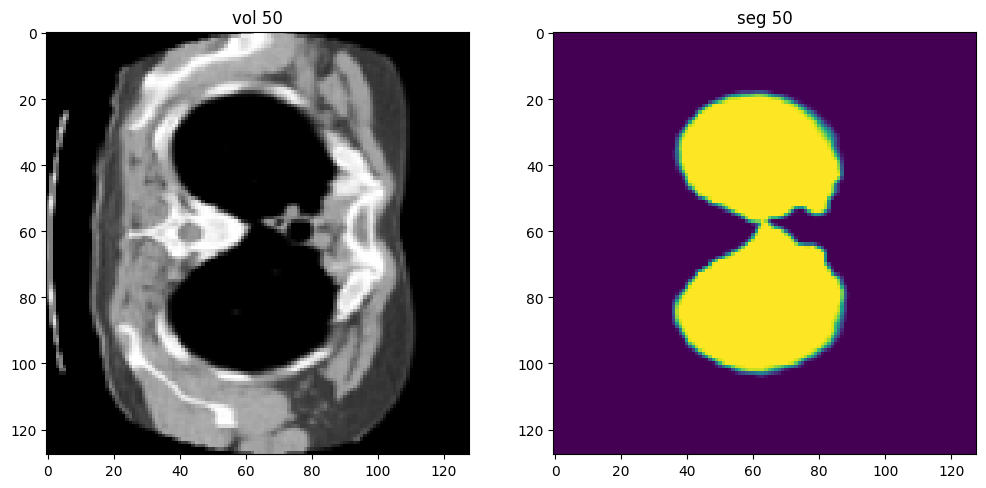

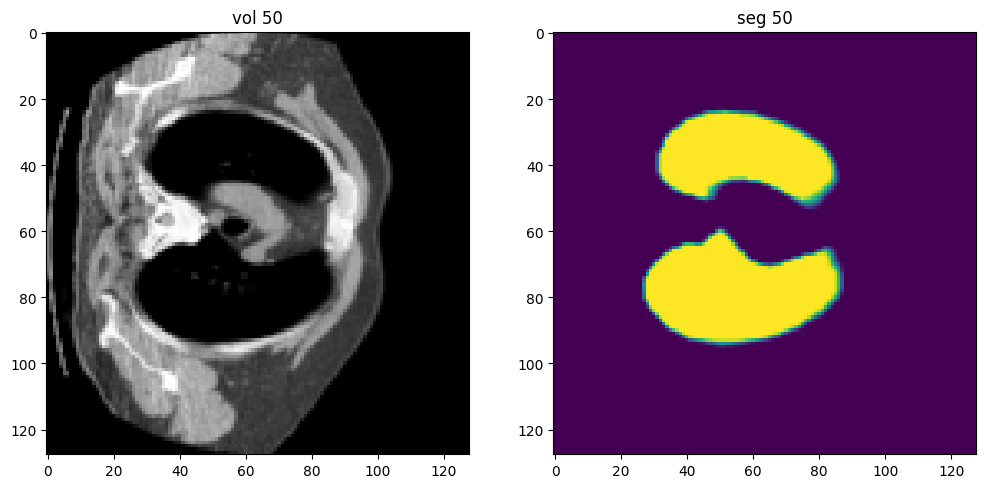

In [26]:
#checking one slice of the data
patient=prepare(in_dir=PATH, label_dir='/tmp')
show_patient(patient, 50)

Calculating the pixels of the foreground and background for the weight function that we will use later for calculating the loss

In [27]:
def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

In [28]:
check_patient_train, check_patient_valid , check_patient_test= patient

In [29]:
calculate_pixels(data = check_patient_train)

100%|██████████| 32/32 [05:02<00:00,  9.45s/it]

The last values: [[27481723.  6072709.]]


array([[27481723.,  6072709.]])

Training used as shown in the monai tutorial. Code adjusted to our my implementation

In [30]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def train(model, data_in, loss, optim, max_epochs, model_dir, val_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_val = []
    save_metric_train = []
    save_metric_val = []
    train_loader, val_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:

            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)

            train_loss = loss(outputs, label)

            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % val_interval == 0:

            model.eval()
            with torch.no_grad():
                val_epoch_loss = 0
                val_metric = 0
                epoch_metric_val = 0
                val_step = 0

                for val_data in val_loader:

                    val_step += 1

                    val_volume = val_data["vol"]
                    val_label = val_data["seg"]
                    val_label = val_label != 0
                    val_volume, val_label = (val_volume.to(device), val_label.to(device),)

                    val_outputs = model(val_volume)

                    val_loss = loss(val_outputs, val_label)
                    val_epoch_loss += val_loss.item()
                    val_metric = dice_metric(val_outputs, val_label)
                    epoch_metric_val += val_metric


                val_epoch_loss /= val_step
                print(f'val_loss_epoch: {val_epoch_loss:.4f}')
                save_loss_val.append(val_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_val.npy'), save_loss_val)

                epoch_metric_val /= val_step
                print(f'val_dice_epoch: {epoch_metric_val:.4f}')
                save_metric_val.append(epoch_metric_val)
                np.save(os.path.join(model_dir, 'metric_val.npy'), save_metric_val)

                if epoch_metric_val > best_metric:
                    best_metric = epoch_metric_val
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {val_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

---

##Training

Im using the monai framework to take the unet model from the model zoo.

Im using the Dice Cross Entropy loss which is weighted.Using the Adam optimizer.

I ran it for 600 epochs.

The best model and training metrics are saved in the path mentioned in the train function.

In [31]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch


model_dir = '/dev'
data_in = prepare(in_dir=PATH, label_dir='/tmp', cache=True)



Loading dataset: 100%|██████████| 5/5 [00:51<00:00, 10.30s/it]


In [33]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(27481723,6072709).to(device))
#loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

train(model, data_in, loss_function, optimizer, 600, model_dir)

Streaming output truncated to the last 5000 lines.
19/32, Train_loss: 0.0699
Train_dice: 0.9440
20/32, Train_loss: 0.0335
Train_dice: 0.9790
21/32, Train_loss: 0.0401
Train_dice: 0.9723
22/32, Train_loss: 0.0372
Train_dice: 0.9744
23/32, Train_loss: 0.0339
Train_dice: 0.9787
24/32, Train_loss: 0.0351
Train_dice: 0.9764
25/32, Train_loss: 0.0589
Train_dice: 0.9553
26/32, Train_loss: 0.0920
Train_dice: 0.9244
27/32, Train_loss: 0.0350
Train_dice: 0.9762
28/32, Train_loss: 0.0549
Train_dice: 0.9582
29/32, Train_loss: 0.0391
Train_dice: 0.9737
30/32, Train_loss: 0.0343
Train_dice: 0.9782
31/32, Train_loss: 0.0473
Train_dice: 0.9669
32/32, Train_loss: 0.0394
Train_dice: 0.9745
--------------------
Epoch_loss: 0.0472
Epoch_metric: 0.9663
val_loss_epoch: 0.1004
val_dice_epoch: 0.9533
current epoch: 532 current mean dice: 0.9432
best mean dice: 0.9533 at epoch: 532
----------
epoch 533/600
1/32, Train_loss: 0.0327
Train_dice: 0.9799
2/32, Train_loss: 0.0405
Train_dice: 0.9723
3/32, Train_loss:

##Testing

Now that the training part is finished, and we are getting good dice scores, lets look at the training metrics

In [34]:
#These metric files are saved in the directory mentioned in the training function
train_loss = np.load('/dev/loss_train.npy')
train_metric = np.load('/dev/metric_train.npy')
test_loss = np.load('/dev/loss_val.npy')
test_metric = np.load('/dev/metric_val.npy')

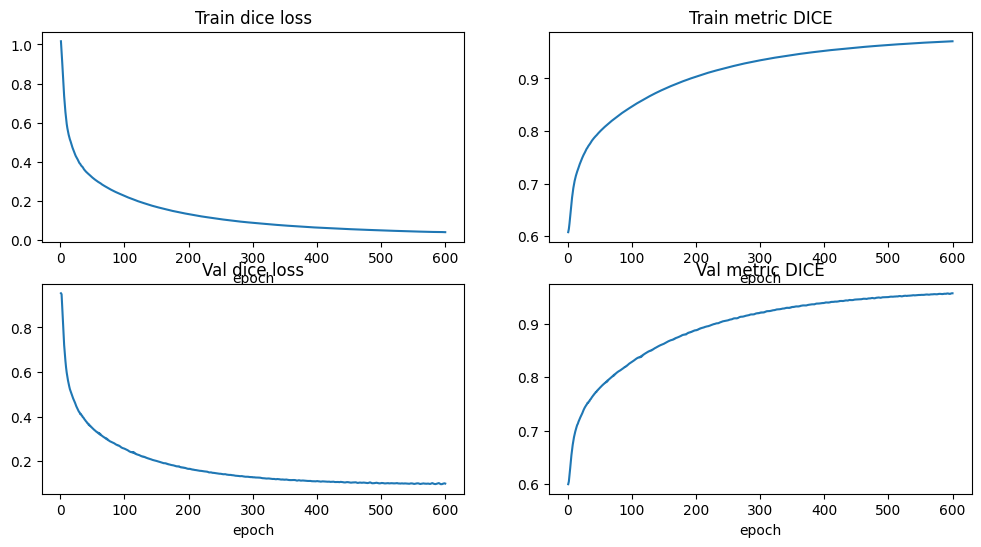

In [37]:
plt.figure("Results 17 dec", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Val dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Val metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [39]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


#loading the saved model
model.load_state_dict(torch.load('/dev/best_metric_model.pth'))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


running all the data from the test set and calculating the avg of the loss and dice scores.

In [54]:
test_loss = 0.0
num_batches = 0
loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(27481723,6072709).to(device))
train_loader, val_loader, test_loader = data_in
test_loss =0
dice_metric_total =0
with torch.no_grad():
  for batch_data in test_loader:

      num_batches += 1

      volume = batch_data["vol"]
      label = batch_data["seg"]
      label = label != 0
      volume, label = (volume.to(device), label.to(device))

      outputs = model(volume)

      test_loss += loss_function(outputs, label)
      dice_metric_total += dice_metric(outputs, label)

average_test_loss = test_loss / num_batches
d_t = dice_metric_total / num_batches
print(f"Average Test Loss: {average_test_loss}")
print(f"Average dice : {d_t}")

Average Test Loss: 0.09744419157505035
Average dice : 0.9611254930496216


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.losses.dice DiceCELoss.__init__:ce_weight: Argument `ce_weight` has been deprecated since version 1.2. It will be removed in version 1.4. please use `weight` instead.
  warn_deprecated(argname, msg, warning_category)


Average Test Loss: 0.09744419157505035
Average dice : 0.9611254930496216

These are pretty good metrics let us now see the segmentation masks produced for multiple slices of a scan.

---

##Inference module

Now lets display the output segmentation provided by the model

The image on the left is the input image, the image in the centre is the label and the image on the right is the predicted segmentation.

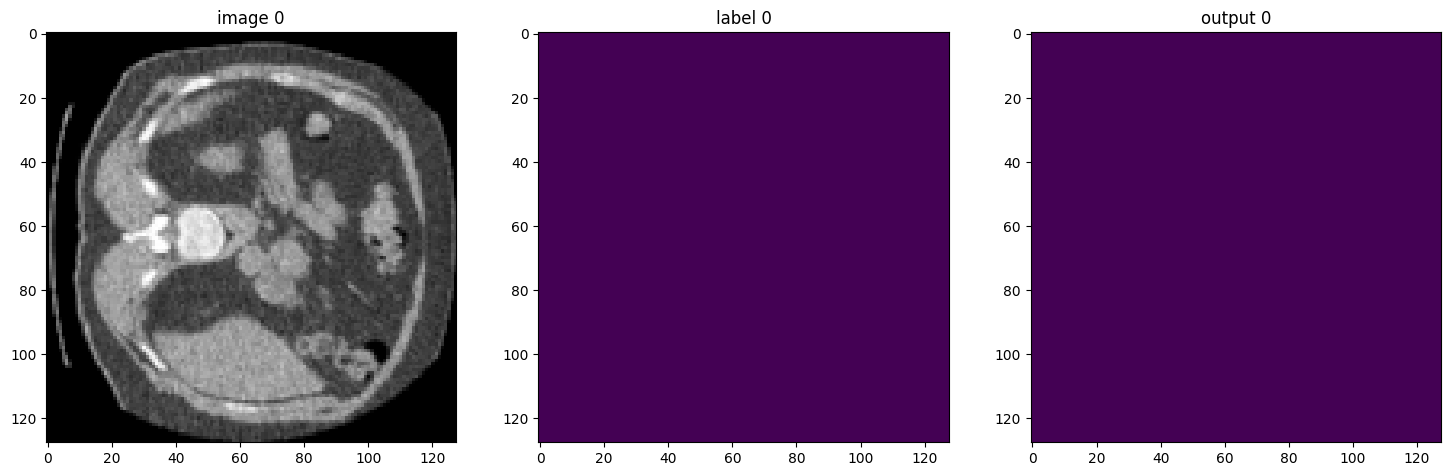

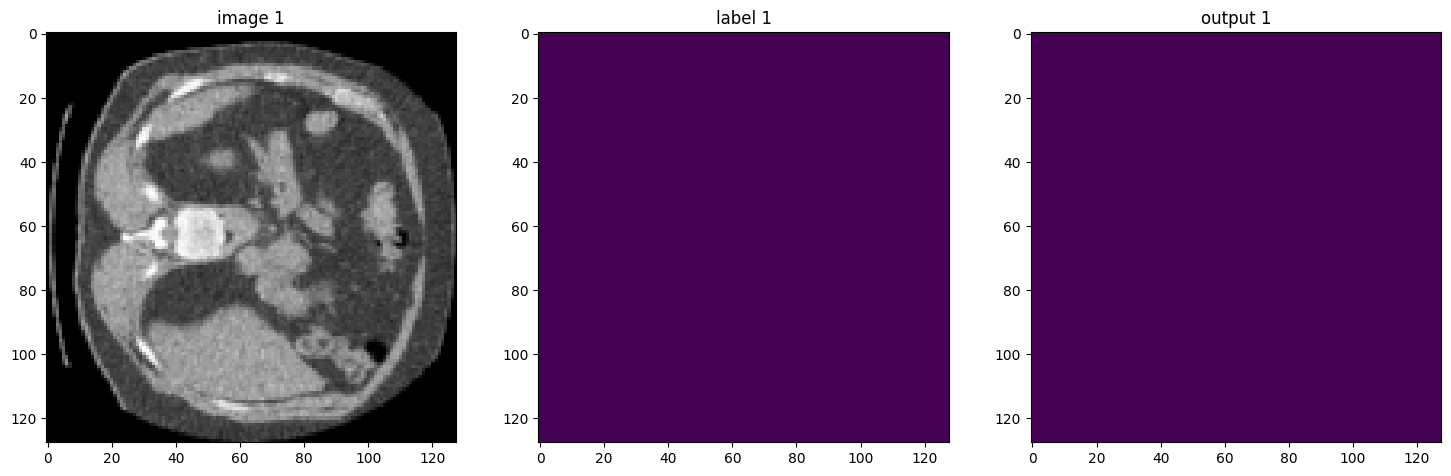

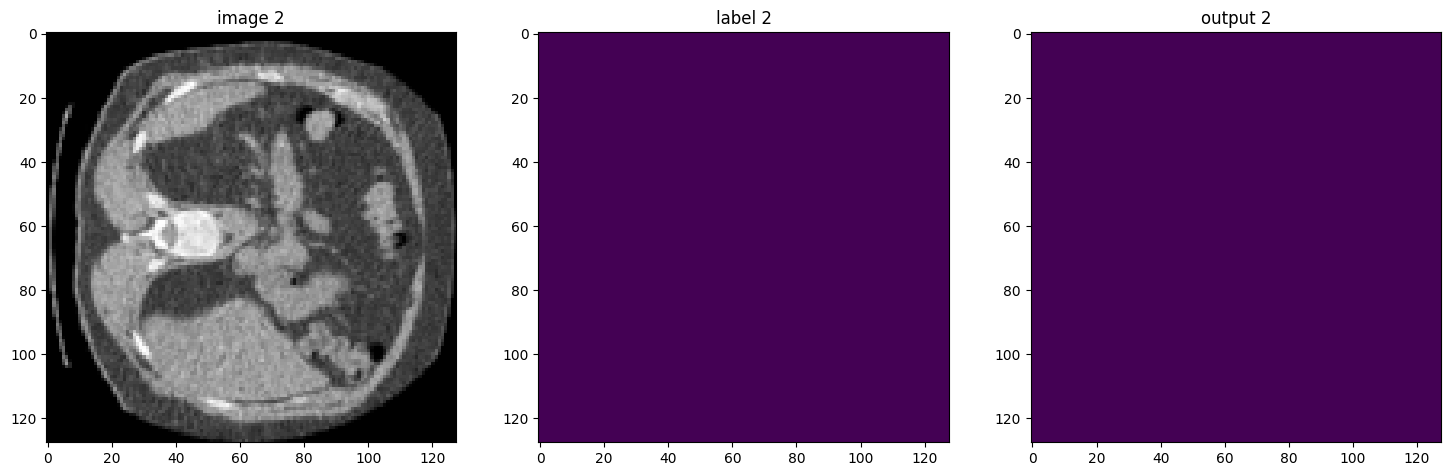

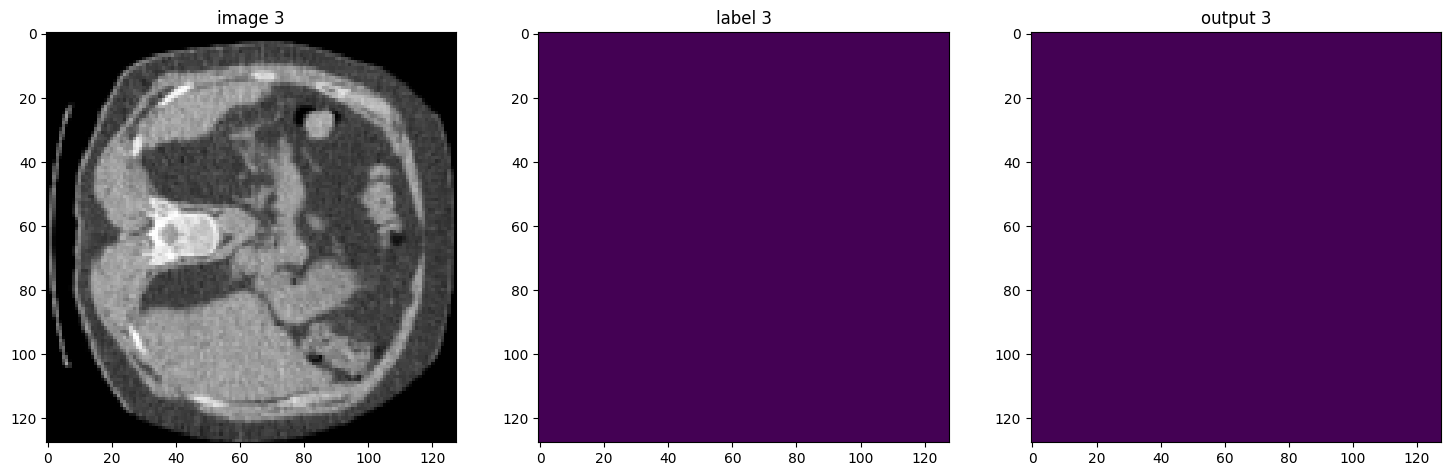

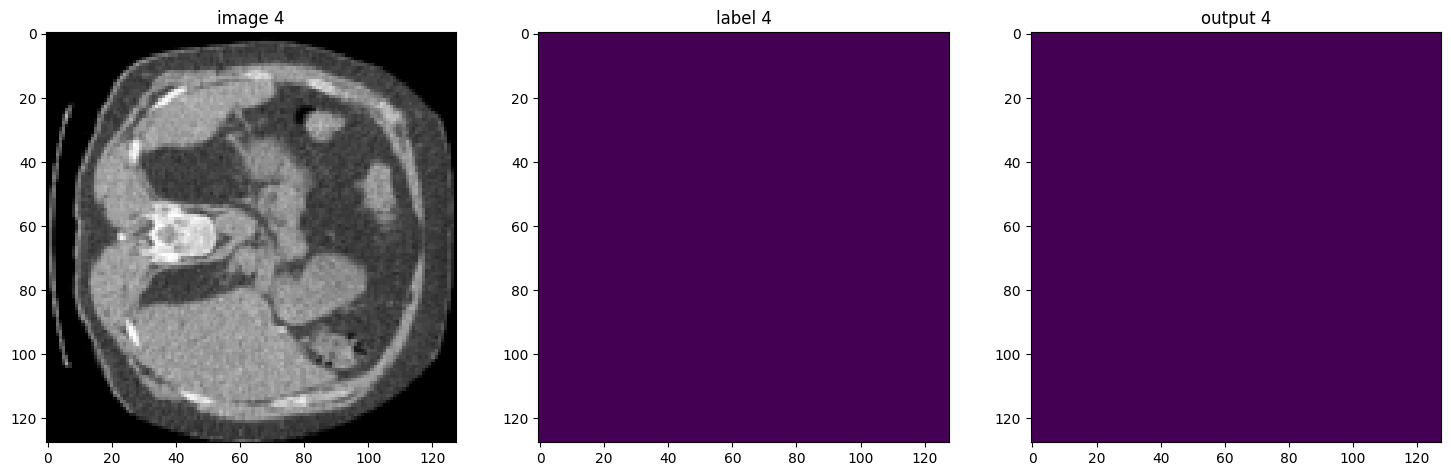

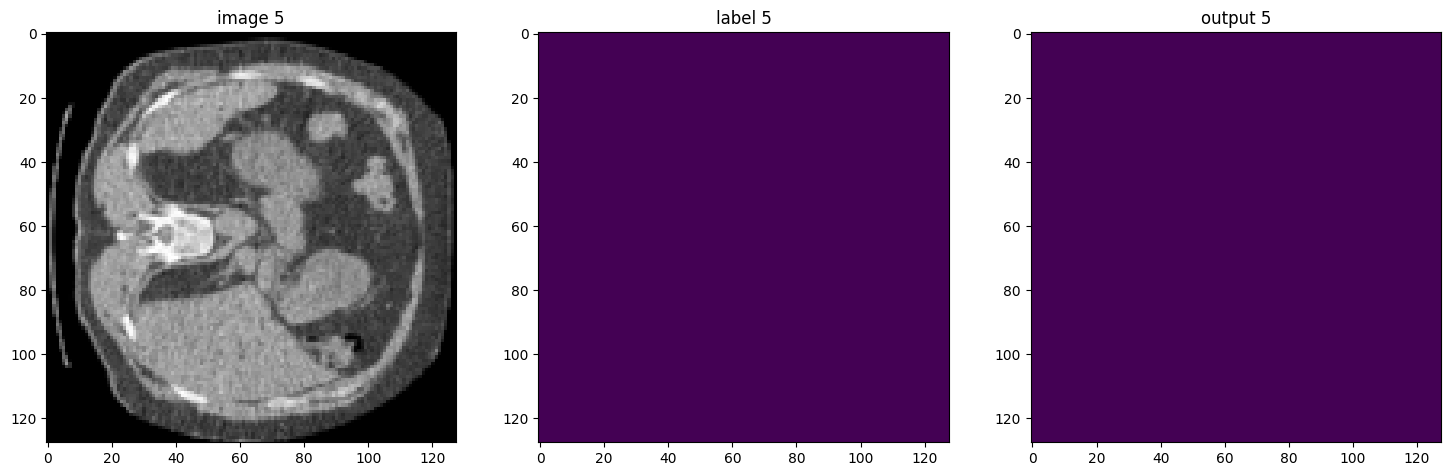

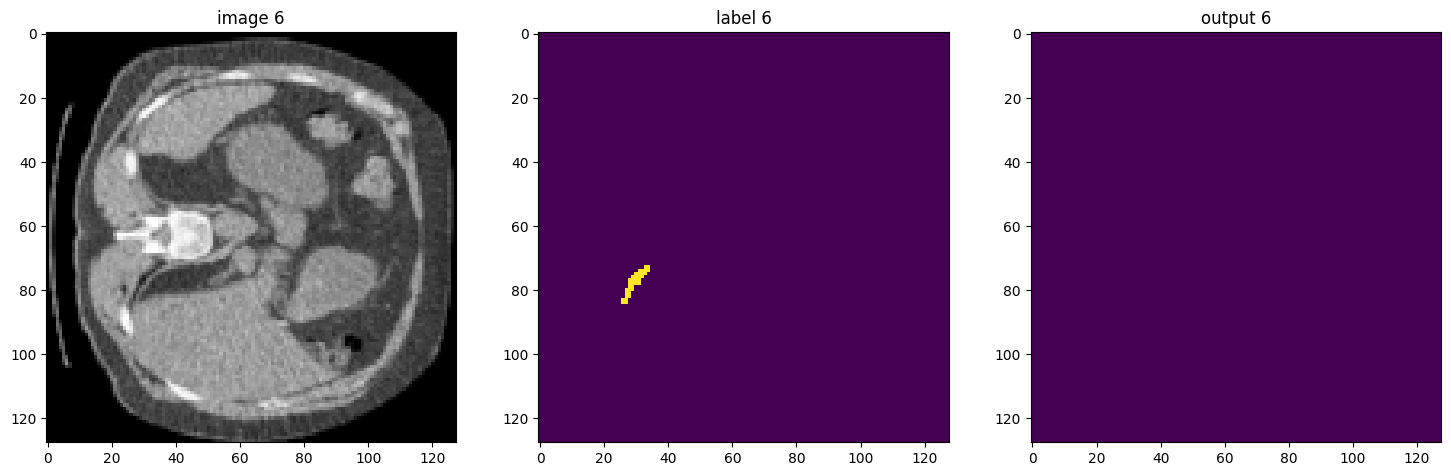

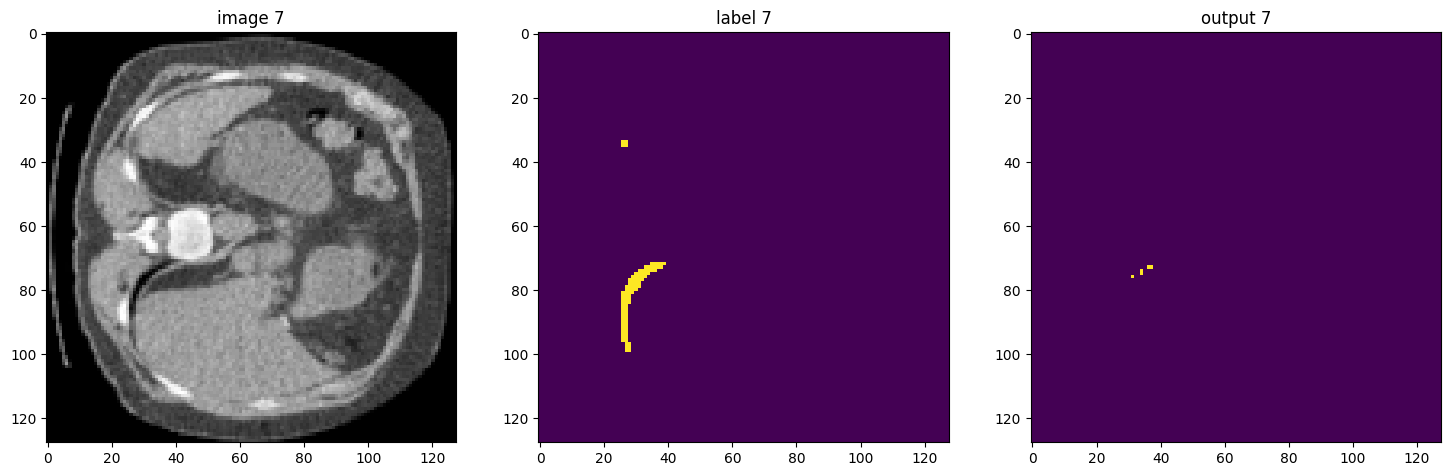

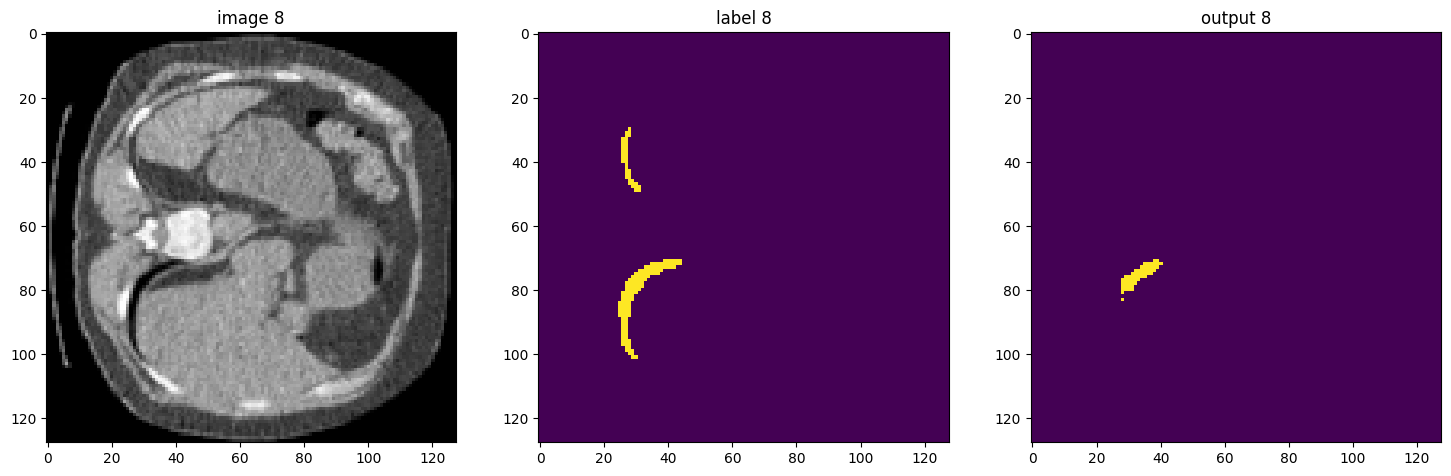

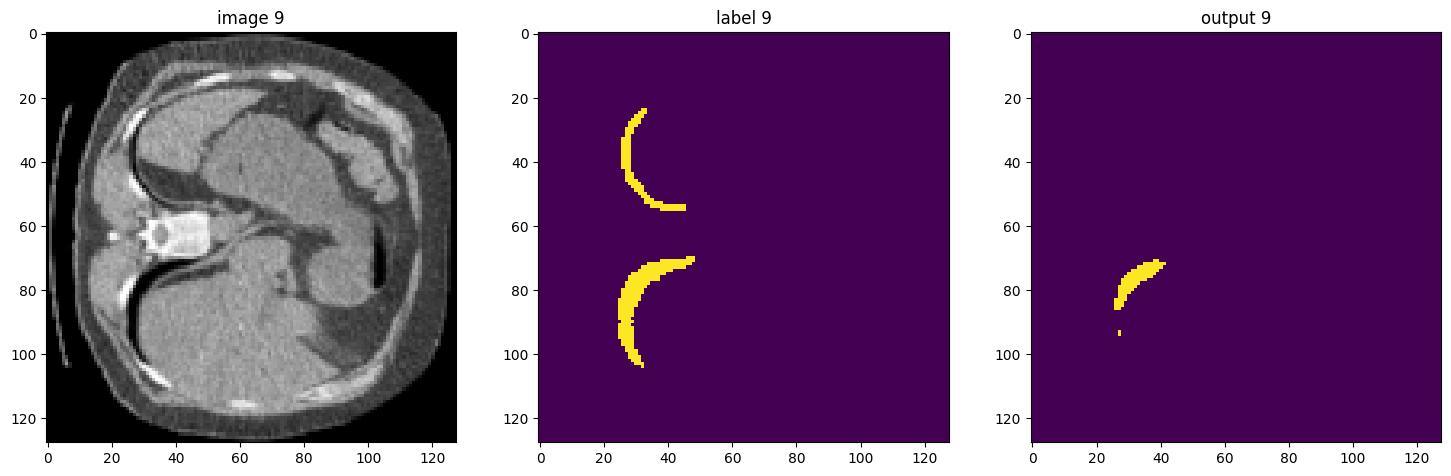

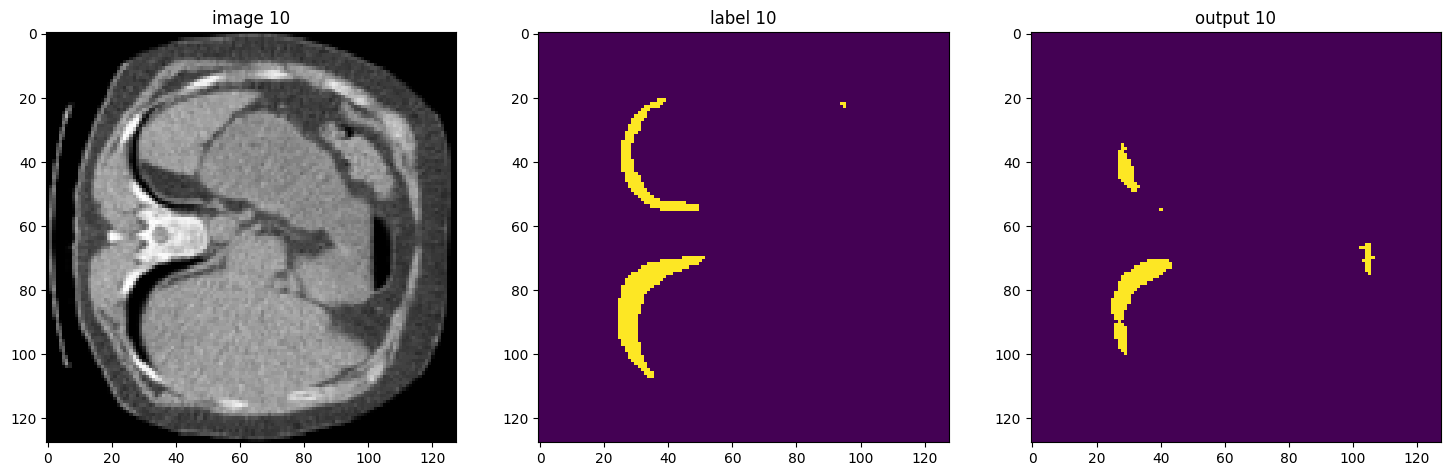

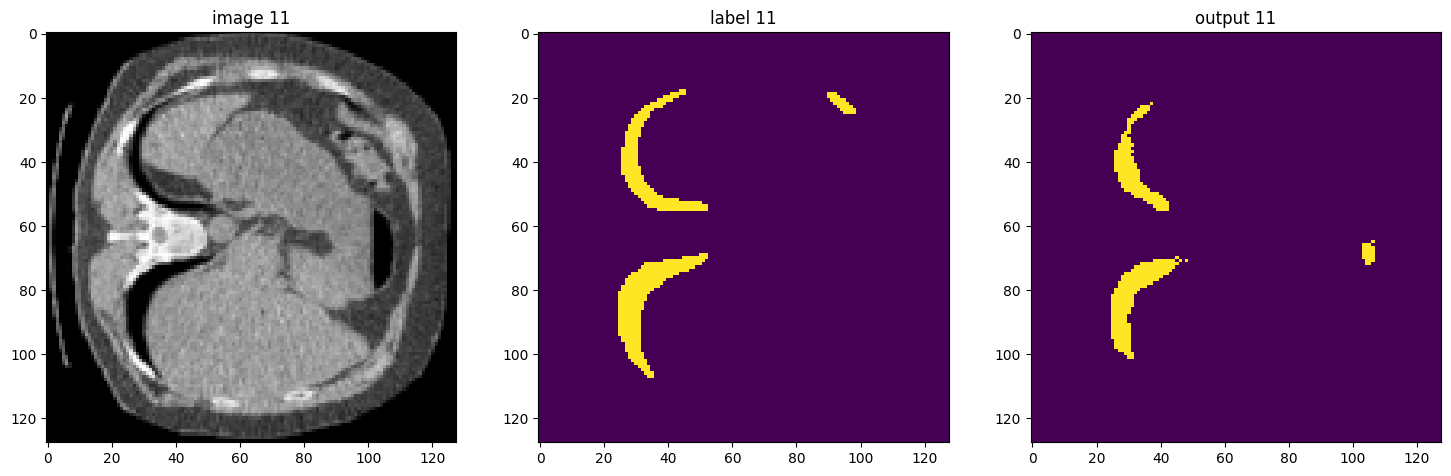

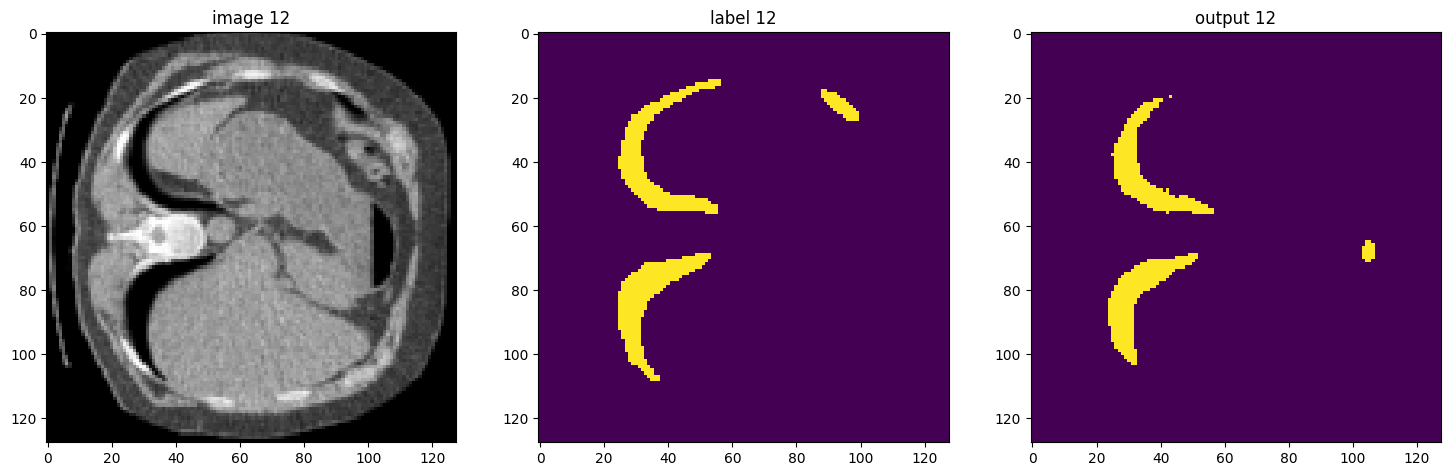

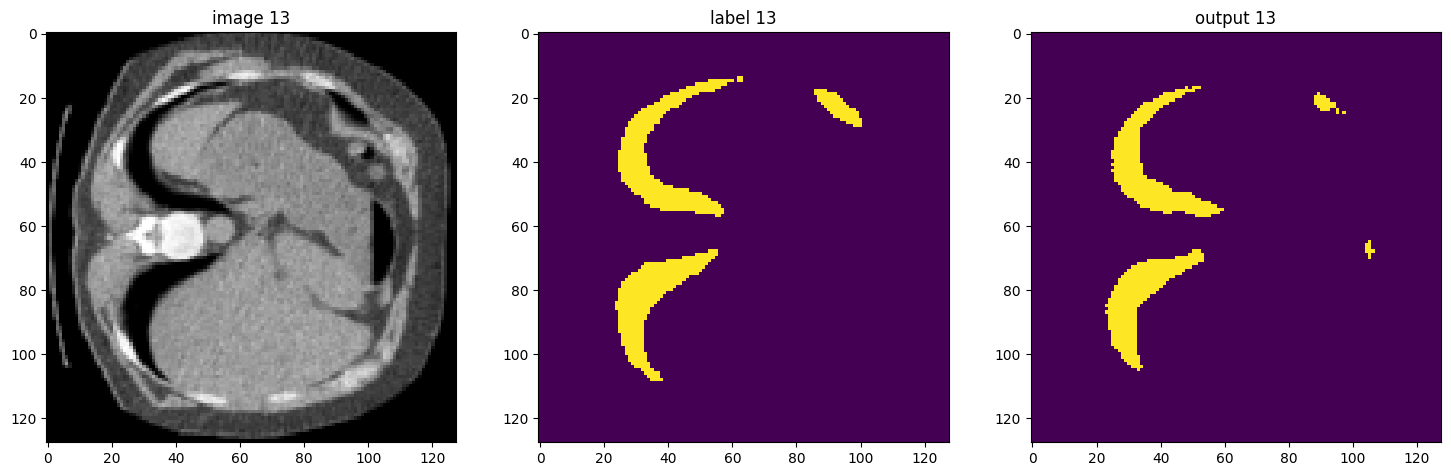

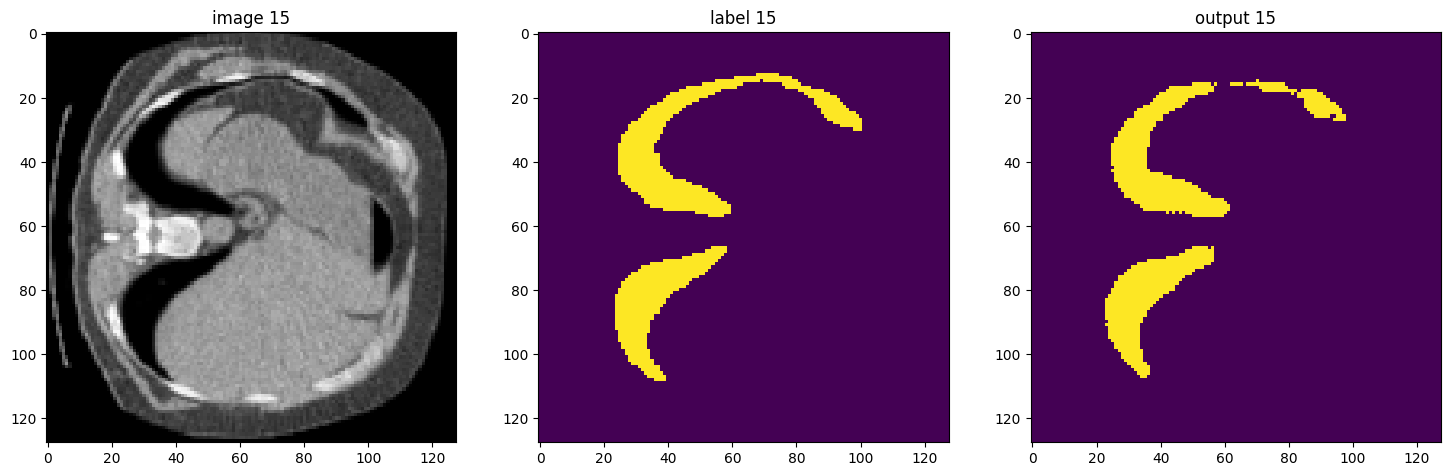

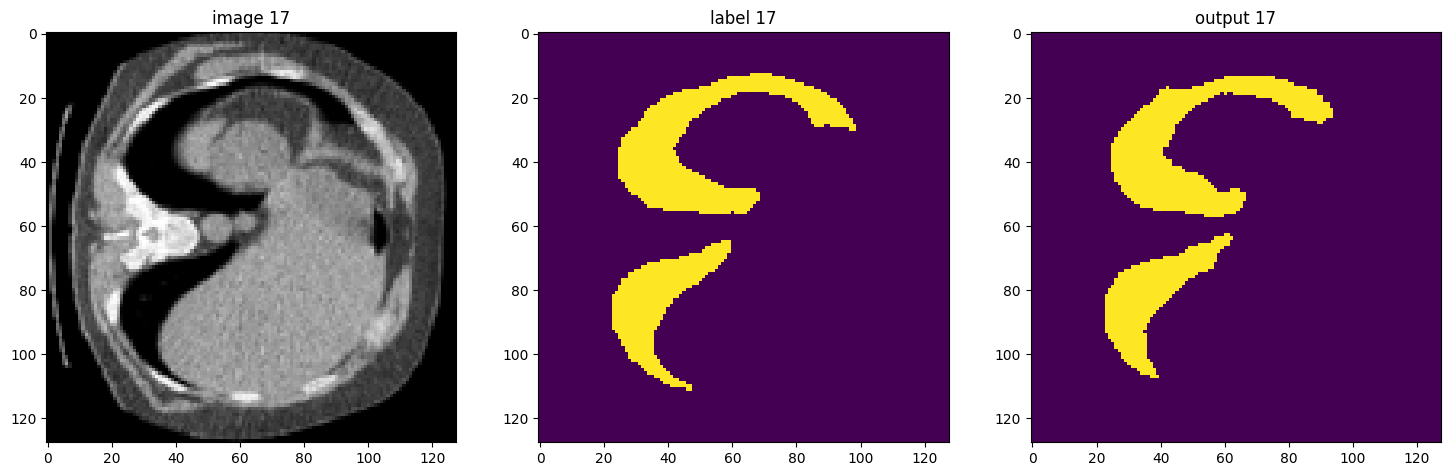

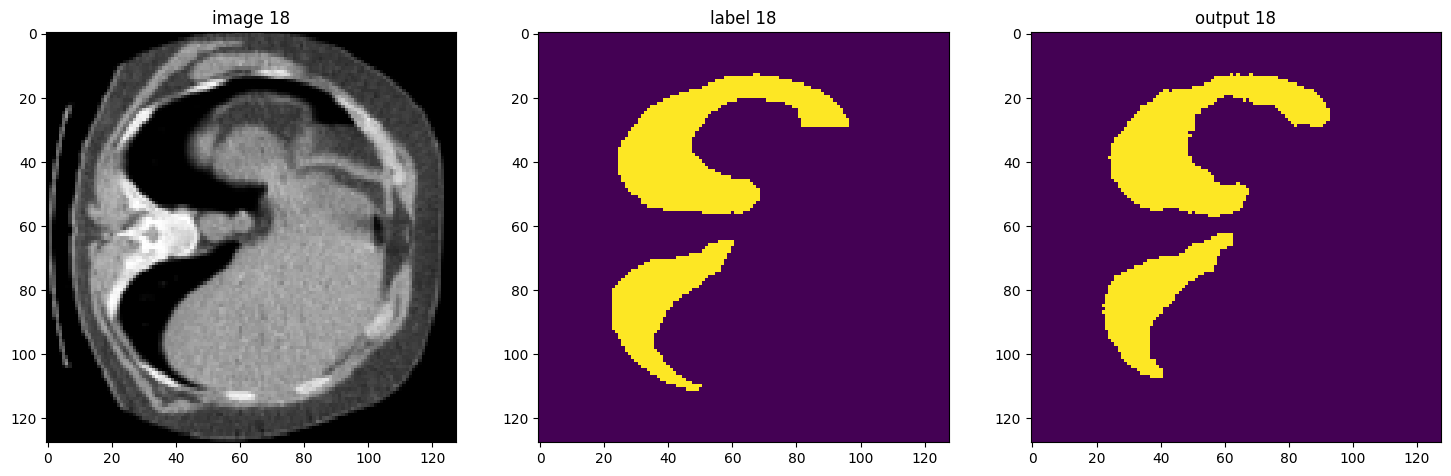

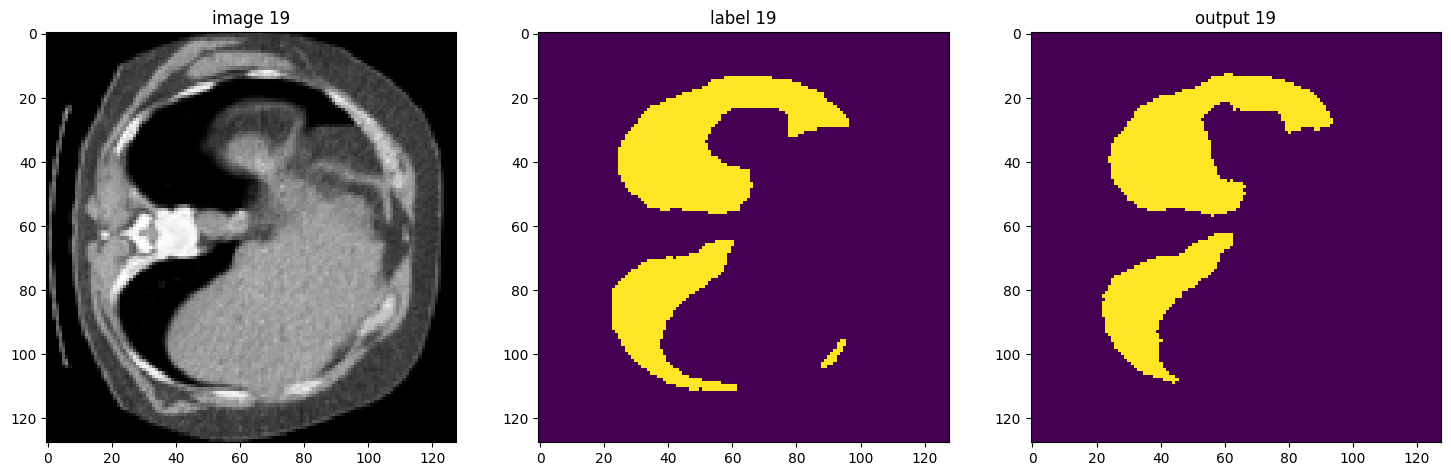

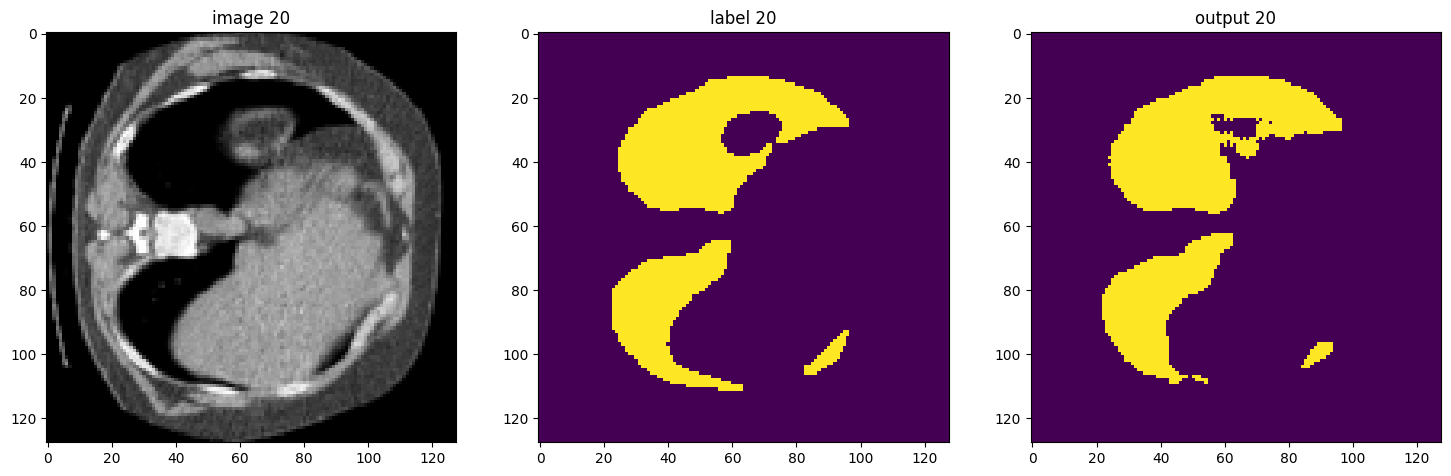

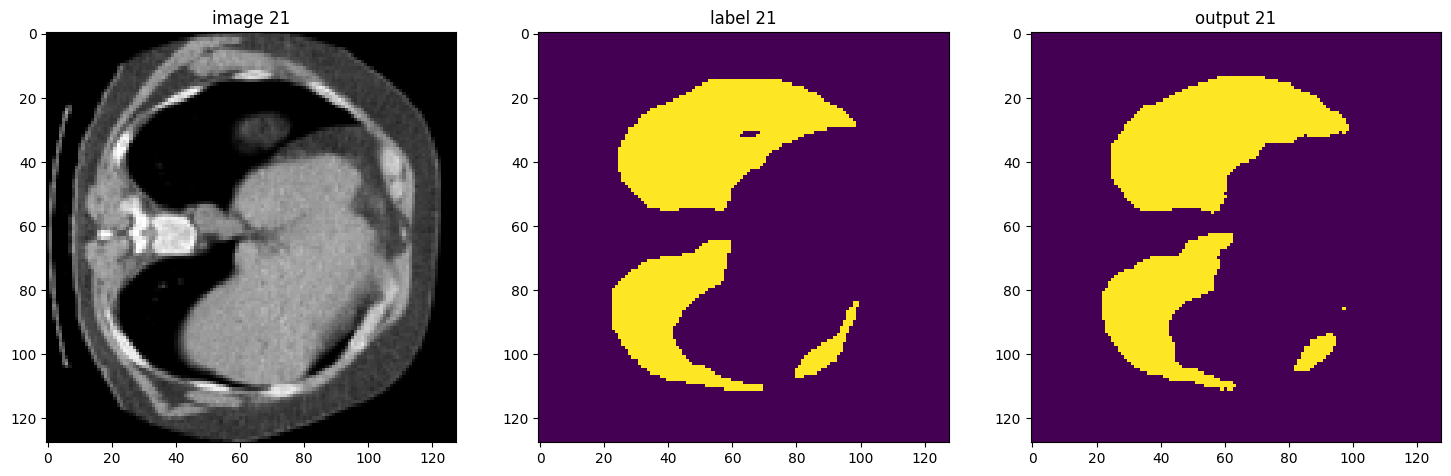

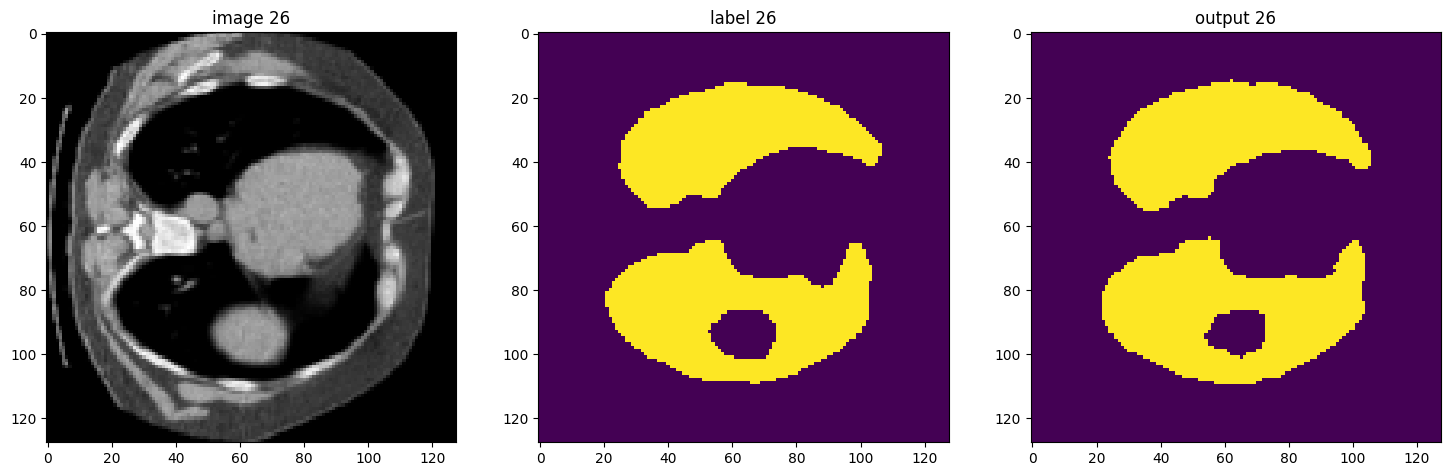

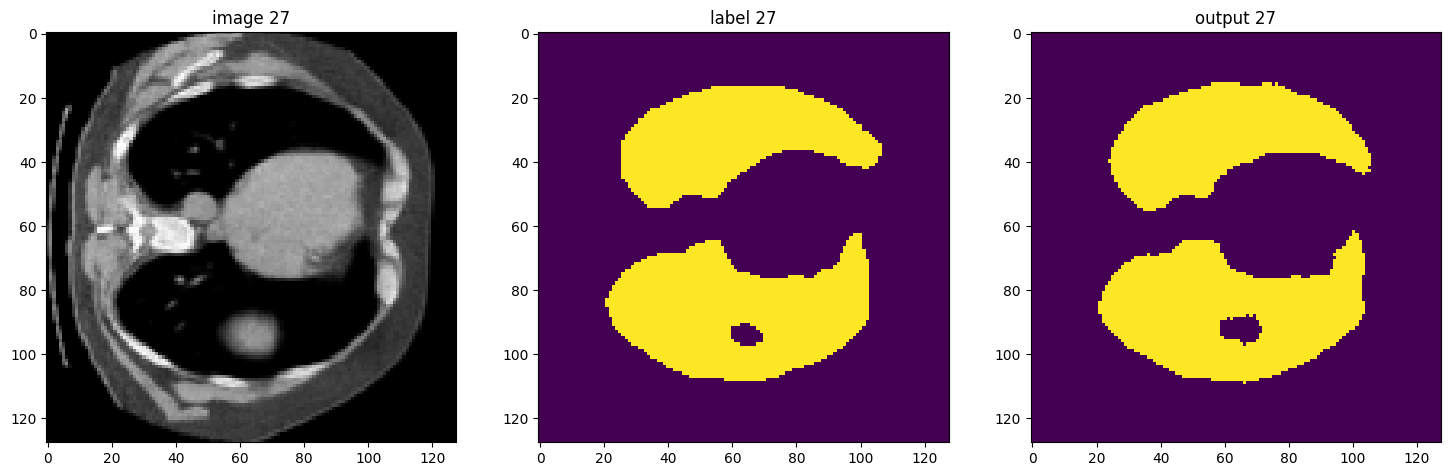

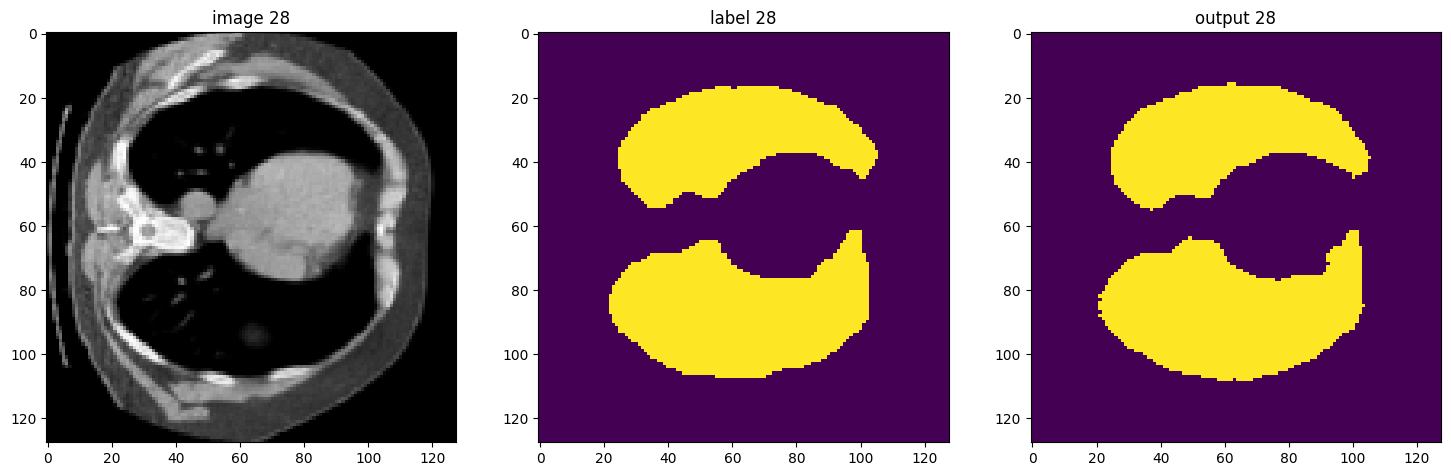

In [40]:
from monai.inferers import sliding_window_inference
from monai.transforms import Activations

train_loader, val_loader, test_loader = data_in
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53

    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()

---

##Running Custom Test Data

If you want to run your test set, you can mention the path of the images dir, labels dir and model path

the subsequent cells should give you the avg metrics over the given test set and also plot the slices and the predictions of the lung segmentation for a particular scan.

In [67]:
!pip install torch

In [68]:
!pip install monai

###some of these might cause a import error if you are running locally, make sure to pip install when an error arises

In [69]:
from monai.inferers import sliding_window_inference
from monai.transforms import Activations
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss
from monai.utils import first
import matplotlib.pyplot as plt
import torch
from monai.losses import DiceLoss
import os
from glob import glob
import shutil
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

**This code assumes that the input labels has segments for left lung, right lung and trachea.
My code will automatically remove trachea and amalgamate left and right lung.**

###change variables below to match your dataset path for image and label as well as model path

In [73]:
#Enter the path of your test set
#Assuming the files are unzipped
input_test_set_images_path="/datalab/imagesTr"
input_test_set_labels_path='/datalab/labelsTr'

input_test_labels_modified = '/tmp'
model_path='/dev/akshath_best_metric_model.pth'

**if your dataset has labels with only lung segment and background then comment out input_test_set_labels and mention your input labels in input_test_labels_modified. You also have to skip the 2 code cells below**

In [74]:
#skip if input has only 2 segments
def process_nifti(input_path, output_path):

    nifti_img = nib.load(input_path)
    data = nifti_img.get_fdata()

    # Eliminate trachea label
    data[data == trachea_label] = 0

    # Amalgamate left and right lung labels
    data[data == left_lung_label] = lung_label
    data[data == right_lung_label] = lung_label

    # Save the processed data to a new NIfTI file
    processed_nifti = nib.Nifti1Image(data, nifti_img.affine)
    nib.save(processed_nifti, output_path)

# Define label values
trachea_label = 5
left_lung_label = 3
right_lung_label = 4
lung_label = 6  # New label for amalgamated lungs

In [75]:
#skip if input has only 2 segments
def process_all_nifti(input_folder, output_folder):

    for filename in os.listdir(input_folder):
        if filename.endswith(".nii.gz"):
            input_path = os.path.join(input_folder, filename)

            # Append "_processed.nii.gz" to the output filename
            output_filename = os.path.splitext(filename)[0][:-4] + "_processed.nii.gz"
            output_path = os.path.join(output_folder, output_filename)

            # Process the NIfTI file
            process_nifti(input_path, output_path)



# Process all NIfTI files in the input folder
process_all_nifti(input_test_set_labels_path, input_test_labels_modified)

In [63]:
def prepare_test(in_dir, label_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=False):
    set_determinism(seed=0)

    # Load image and label paths
    path_images = sorted(glob(os.path.join(in_dir,"*.nii.gz")))
    path_labels = sorted(glob(os.path.join(label_dir, "*.nii.gz")))

    # Organize file paths into dictionaries

    test_files = [{"vol": img, "seg": lbl} for img, lbl in zip(path_images, path_labels)]


    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),


        ]
    )

    test_ds = Dataset(data=test_files, transform=test_transforms)

    test_loader = DataLoader(test_ds, batch_size=1)

    if cache:
        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)

        test_loader = DataLoader(test_ds, batch_size=1)


    return test_loader

In [64]:
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


#loading the saved model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

In [65]:
test_loss = 0.0
num_batches = 0
loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(27481723,6072709).to(device))
test_loader = prepare_test(input_test_set_images_path,input_test_labels_modified)
test_loss =0
dice_metric_total =0
with torch.no_grad():
  for batch_data in test_loader:

      num_batches += 1

      volume = batch_data["vol"]
      label = batch_data["seg"]
      label = label != 0
      volume, label = (volume.to(device), label.to(device))

      outputs = model(volume)

      test_loss += loss_function(outputs, label)
      dice_metric_total += dice_metric(outputs, label)

average_test_loss = test_loss / num_batches
d_t = dice_metric_total / num_batches
print(f"Average Test Loss: {average_test_loss}")
print(f"Average dice : {d_t}")

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.losses.dice DiceCELoss.__init__:ce_weight: Argument `ce_weight` has been deprecated since version 1.2. It will be removed in version 1.4. please use `weight` instead.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Average Test Loss: 0.06121158227324486
Average dice : 0.9652682787842221


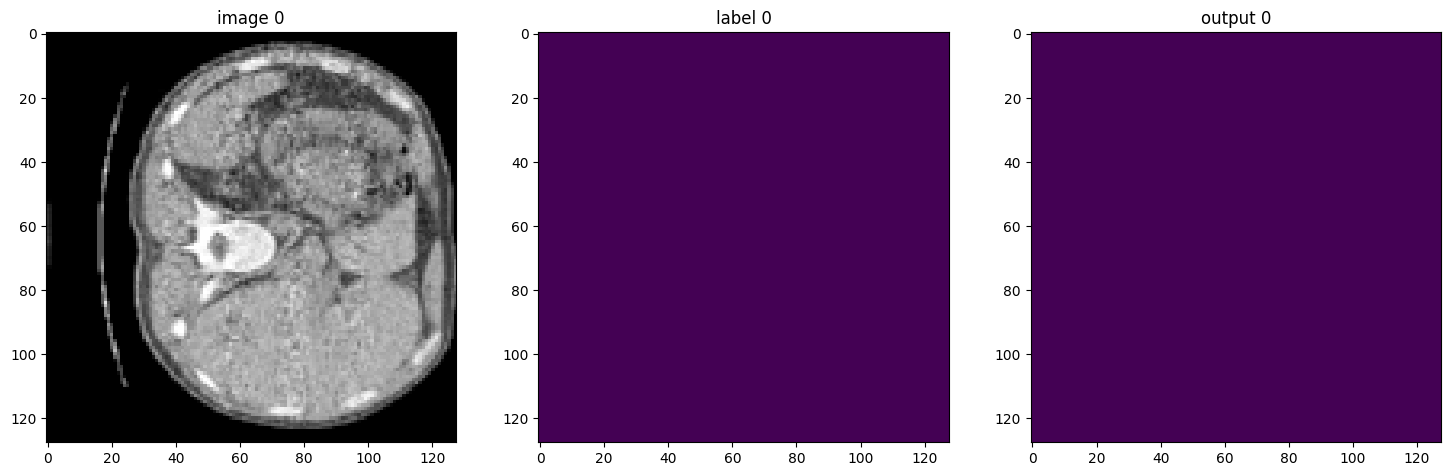

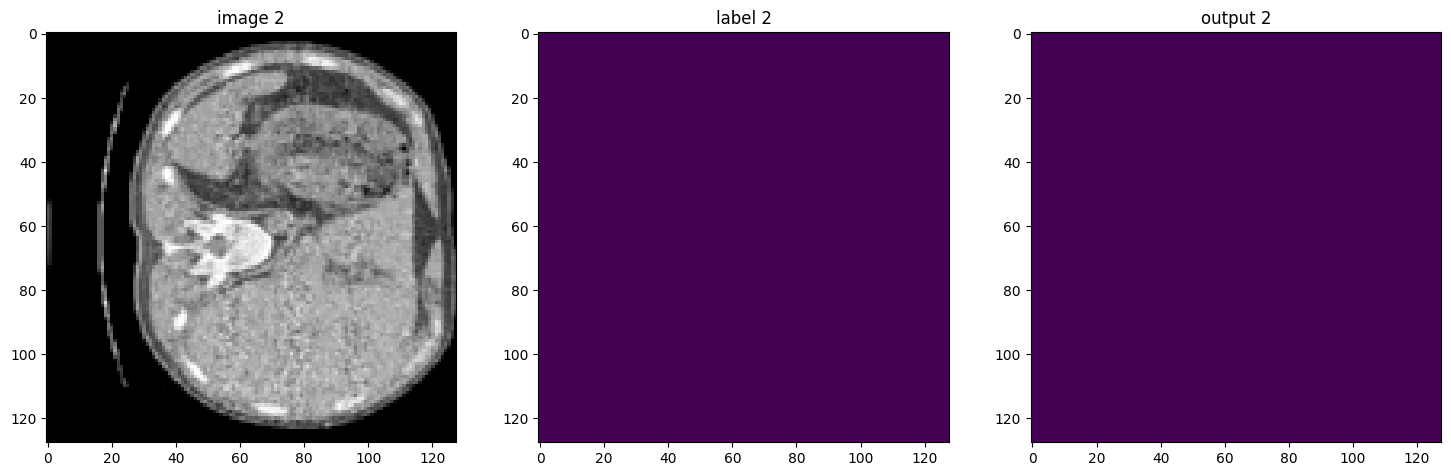

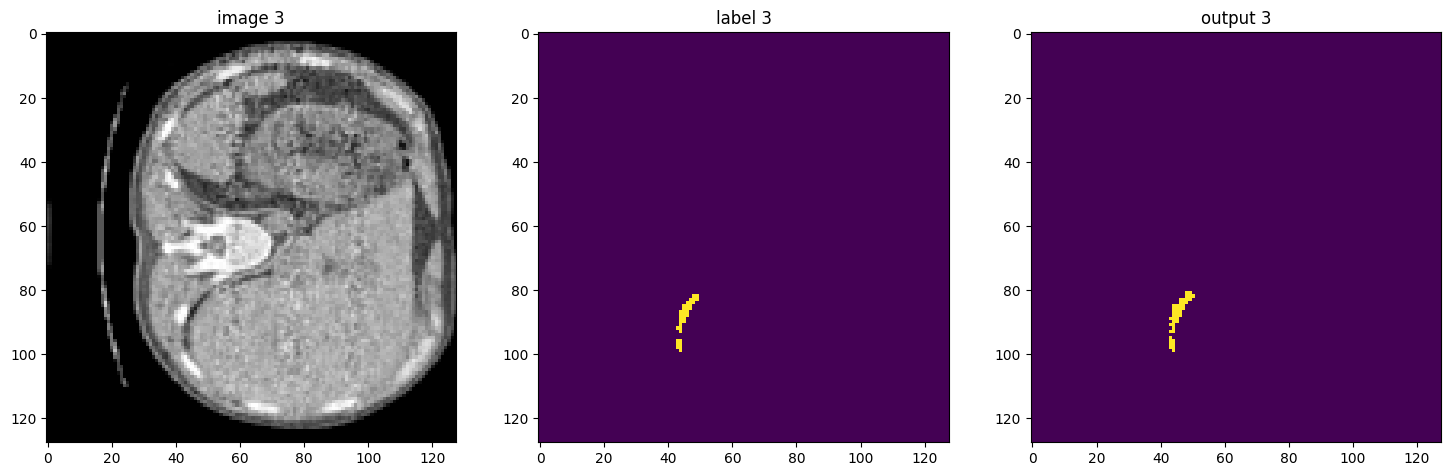

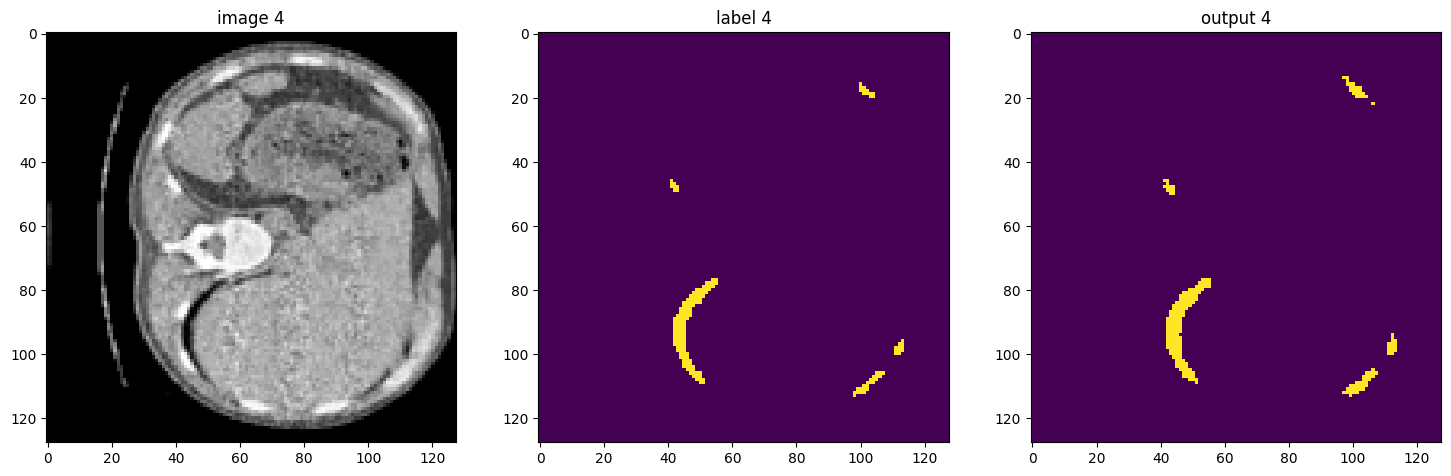

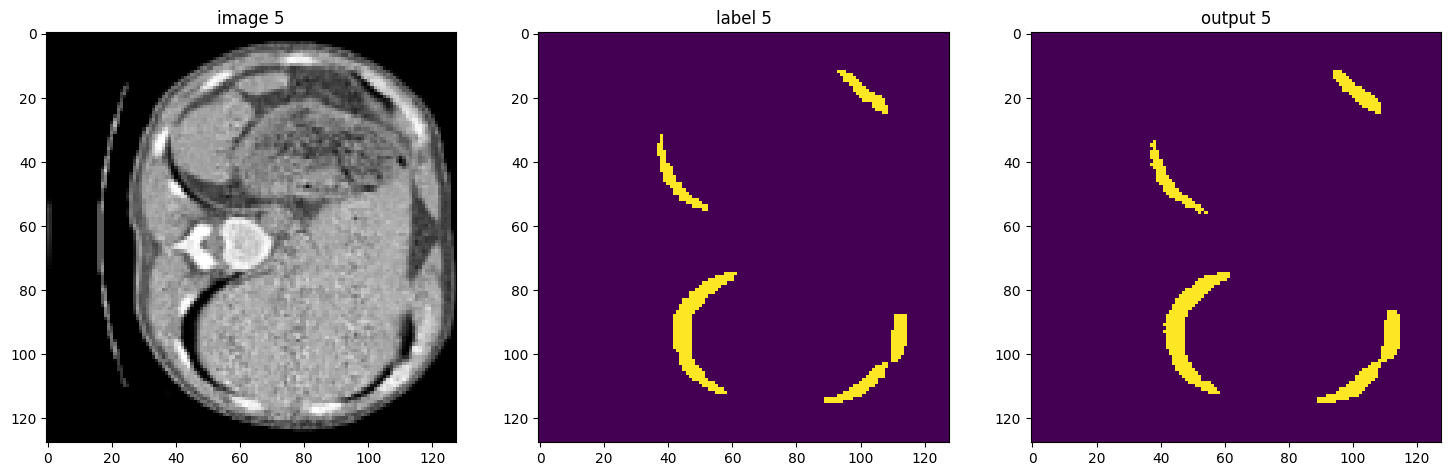

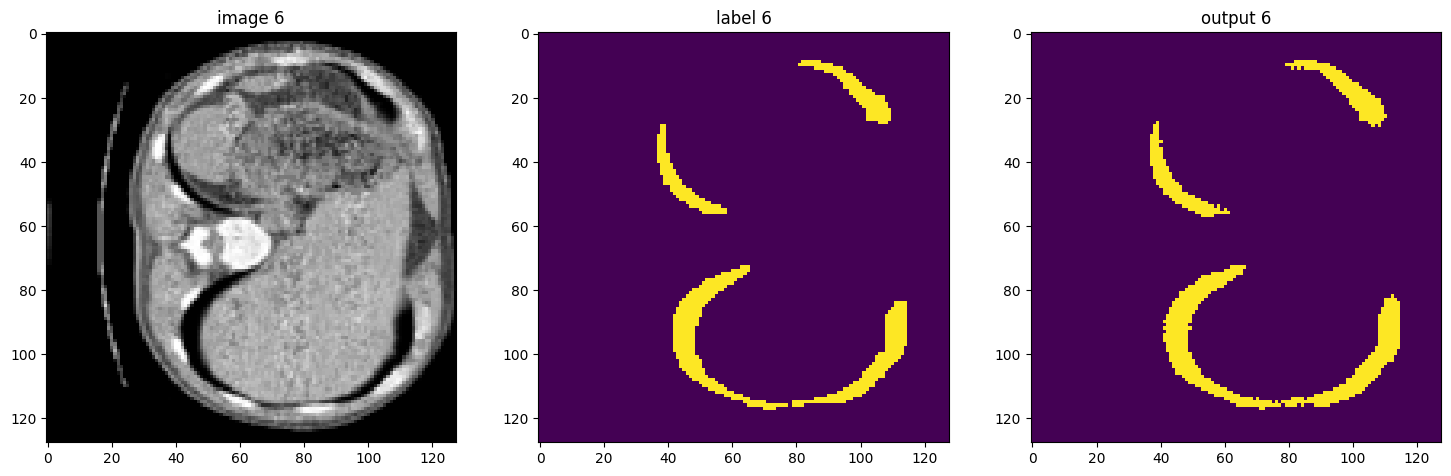

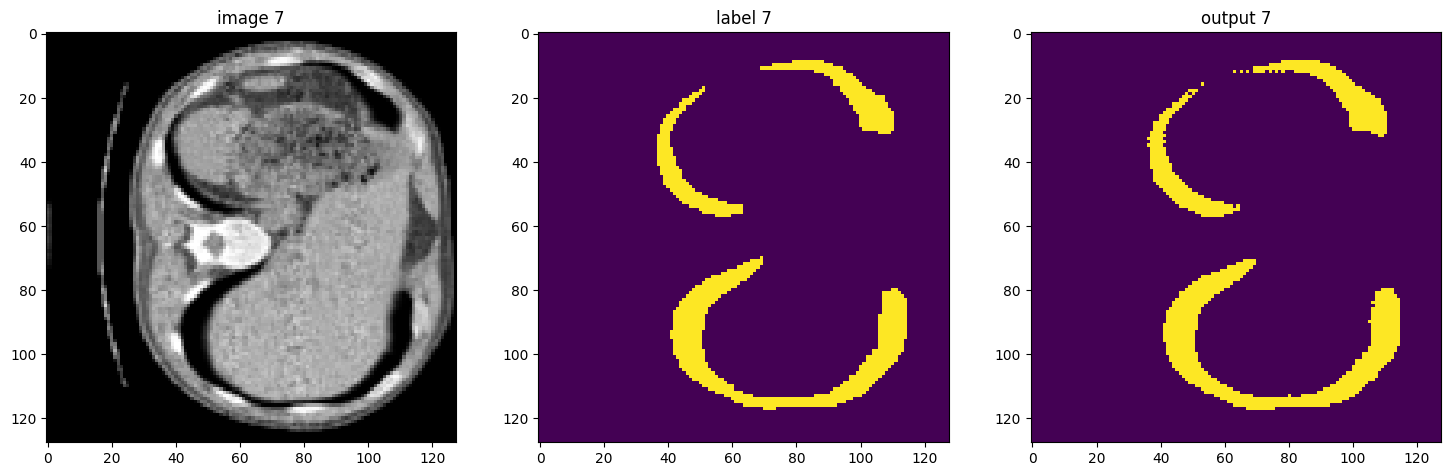

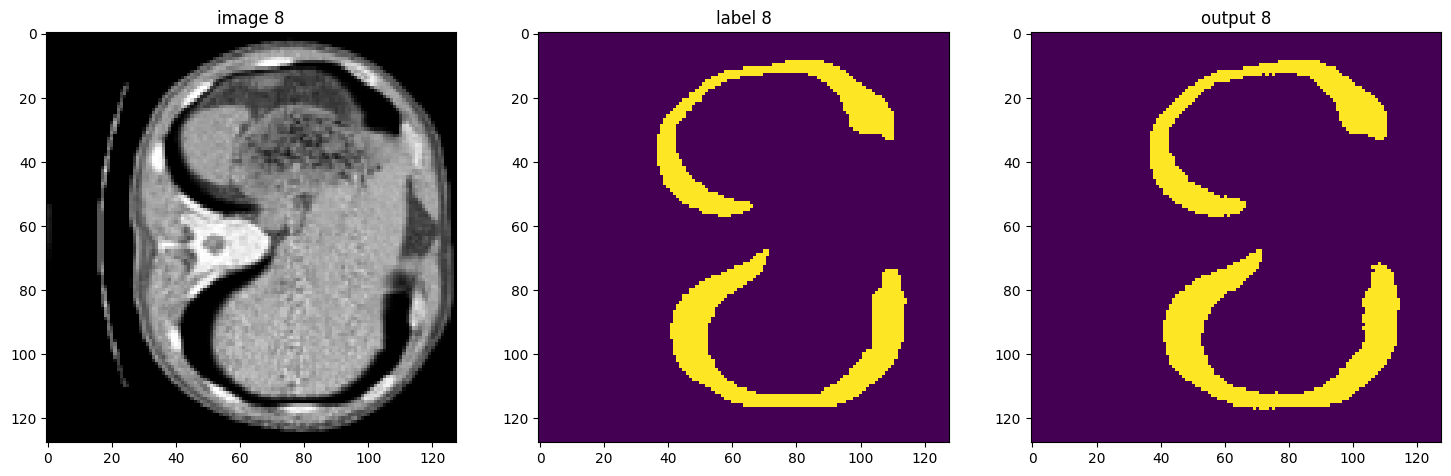

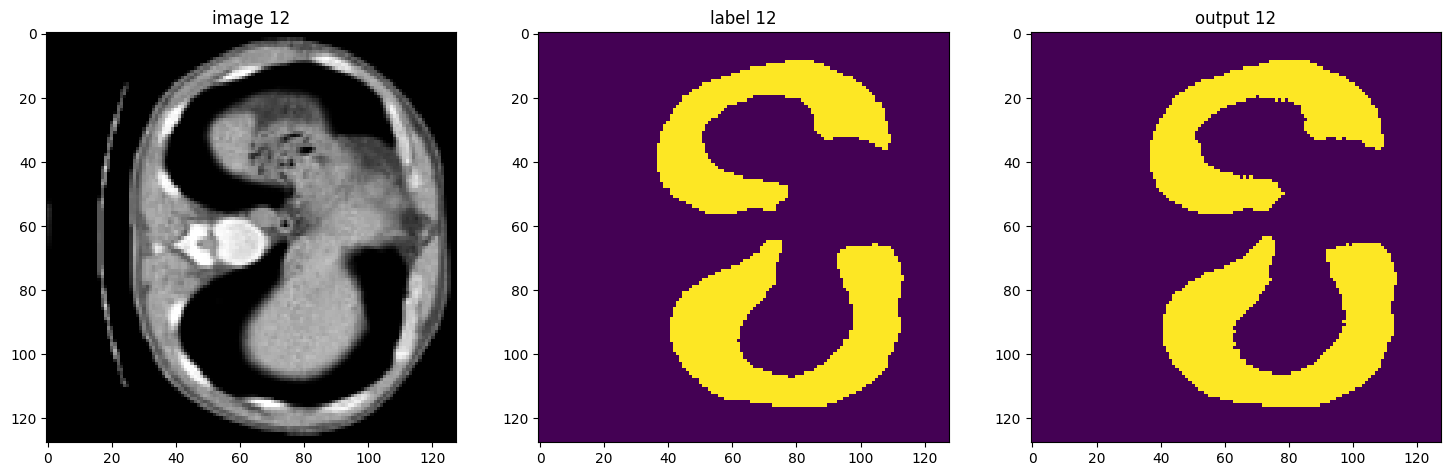

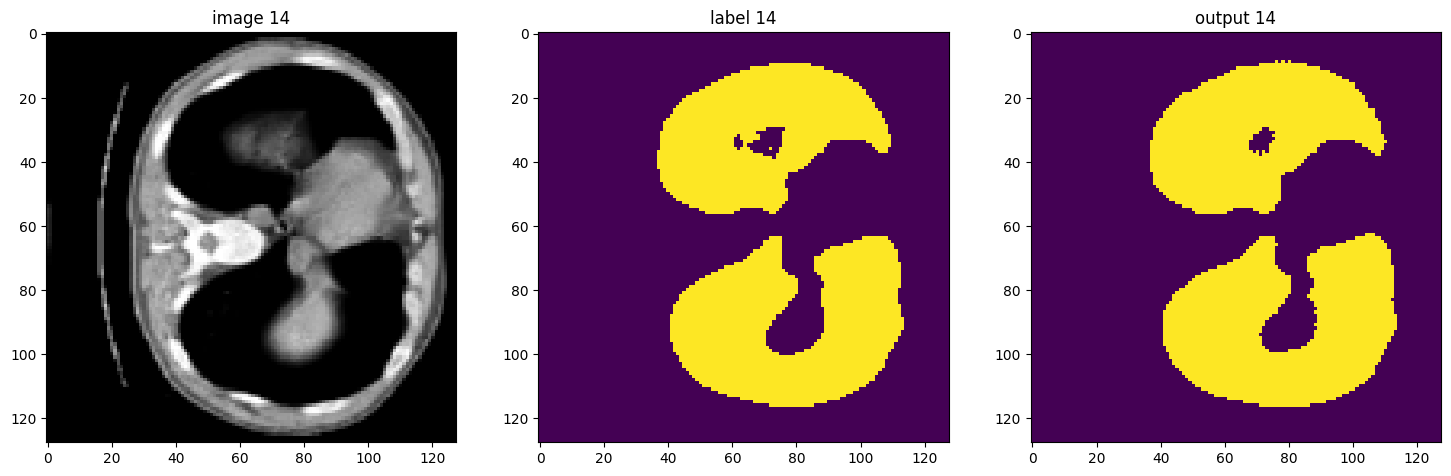

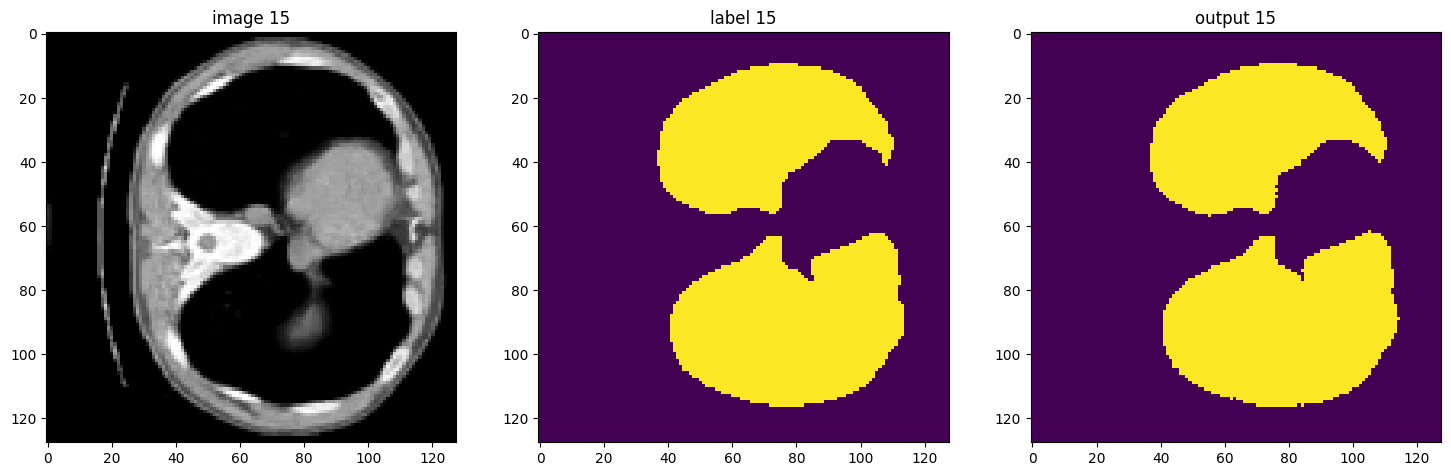

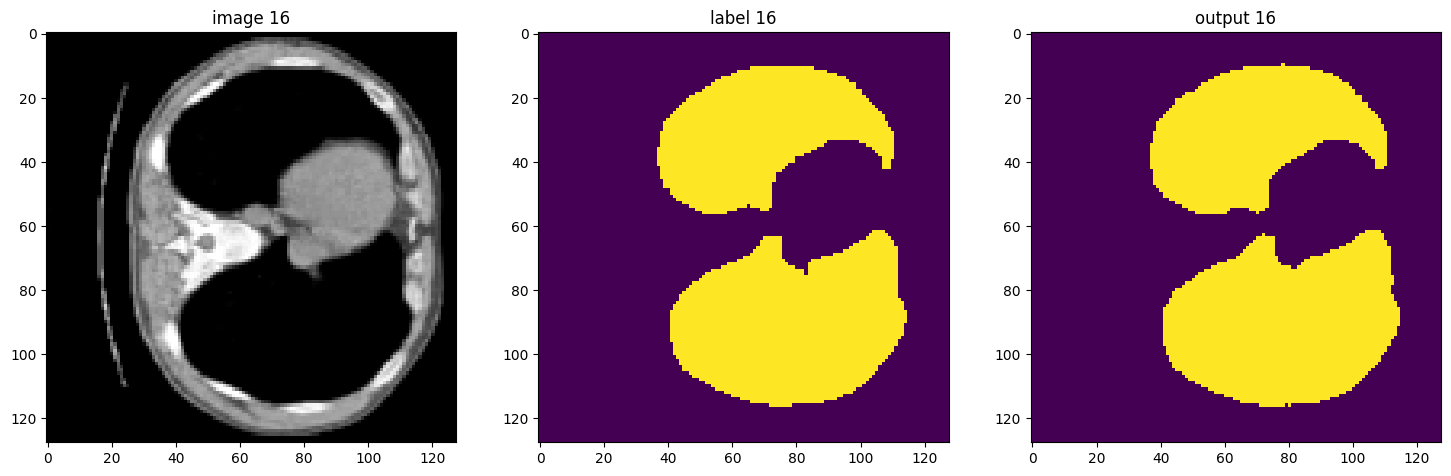

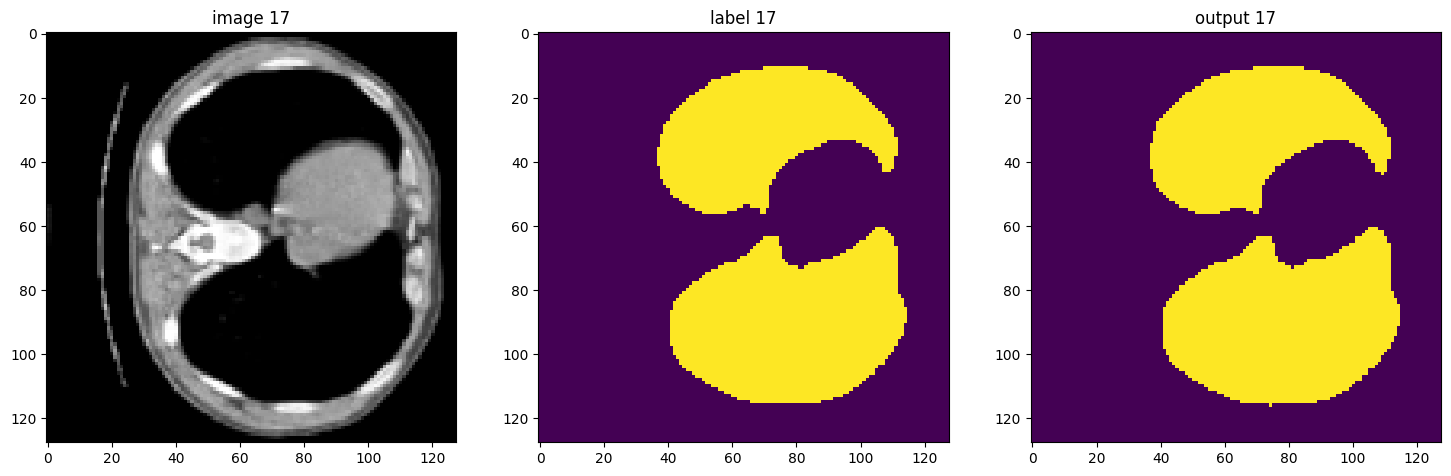

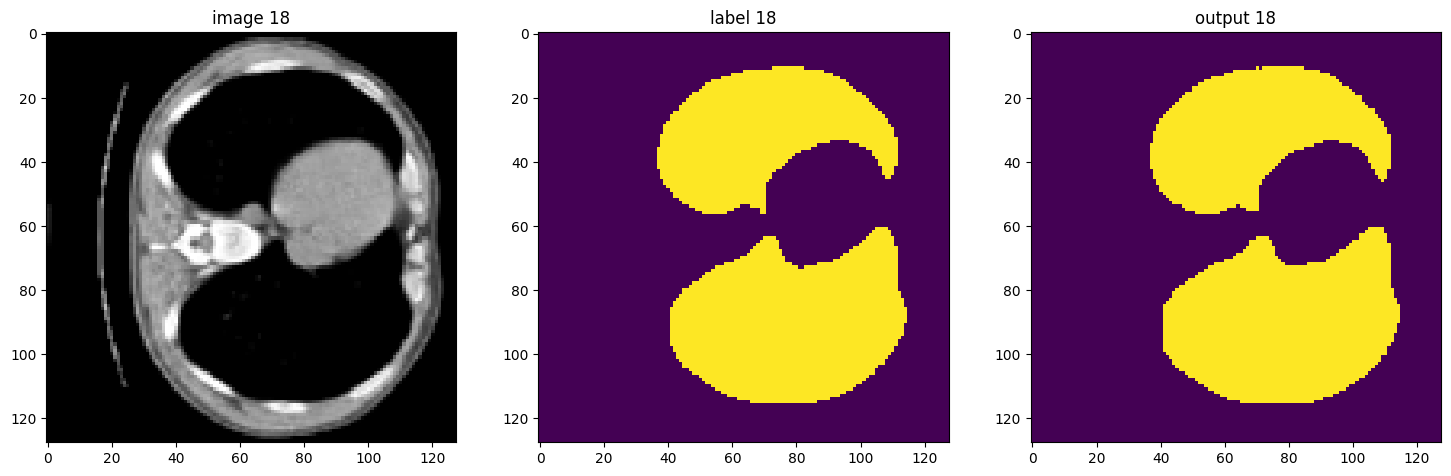

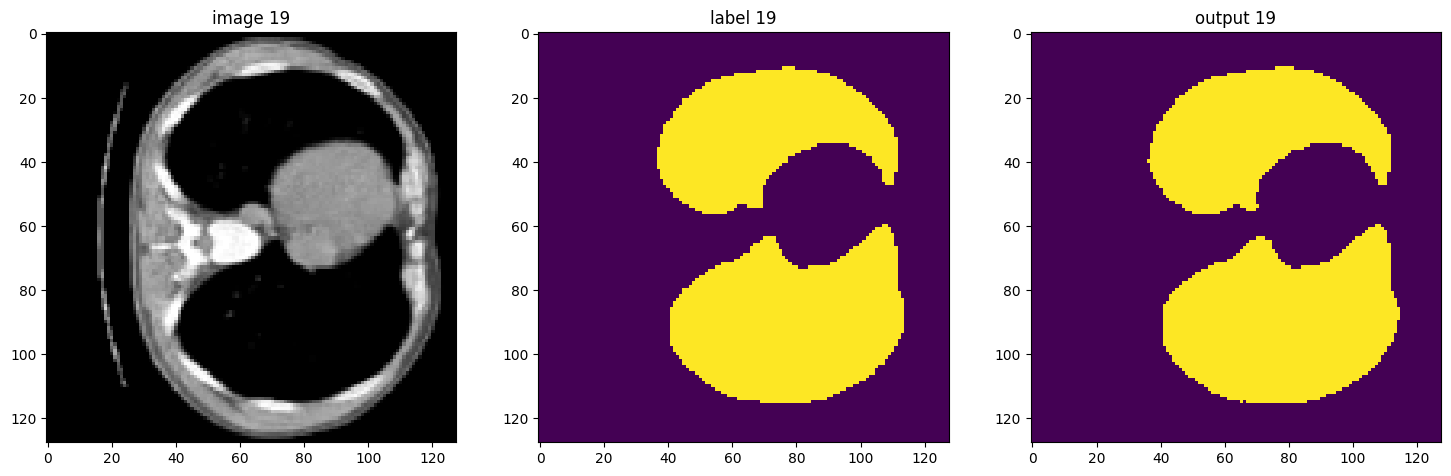

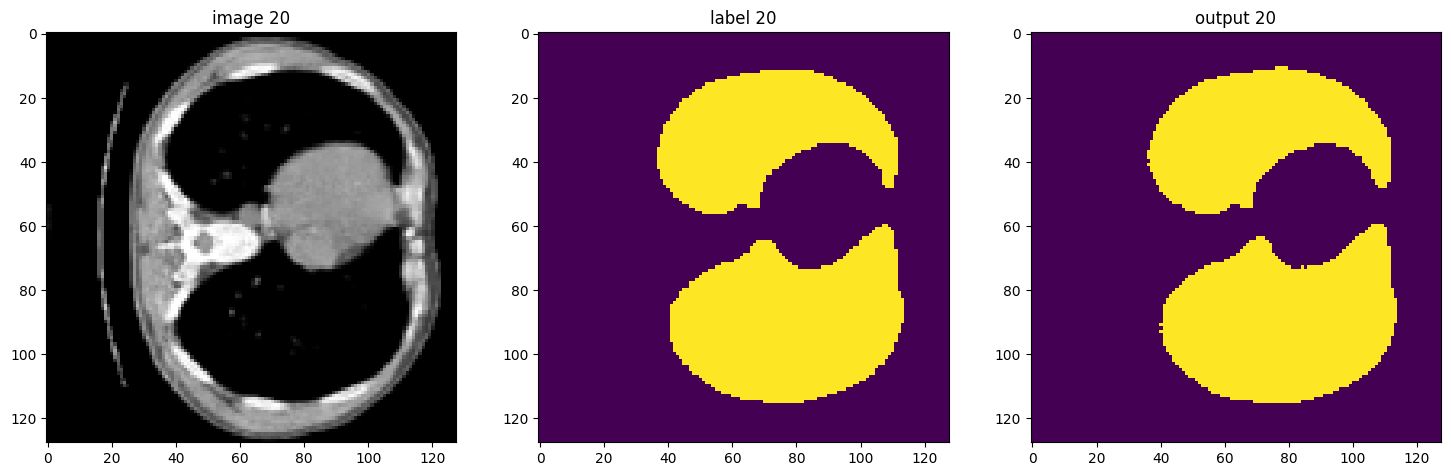

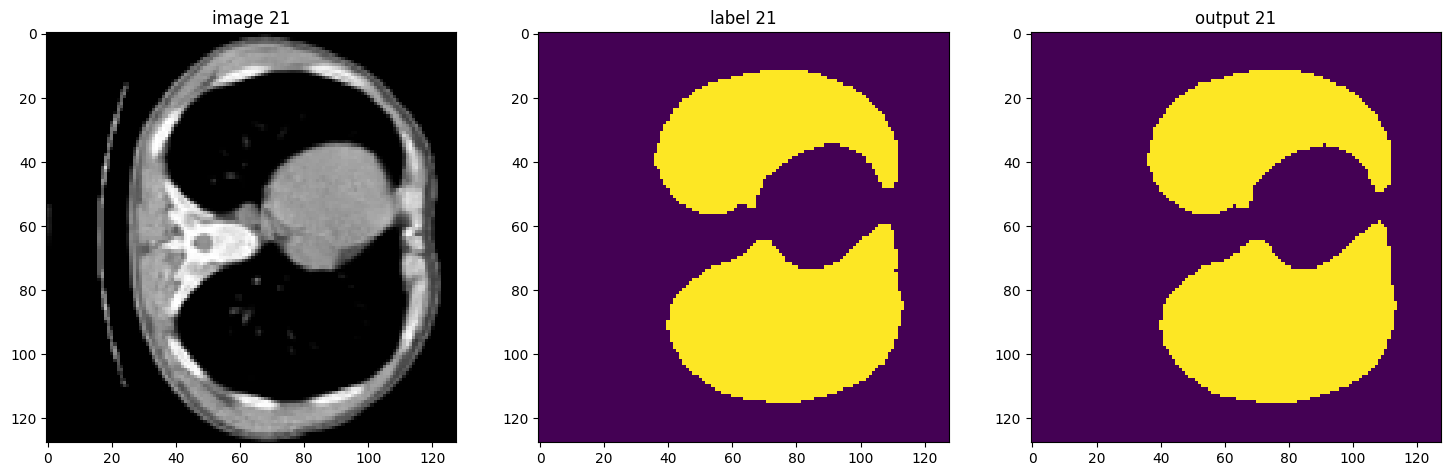

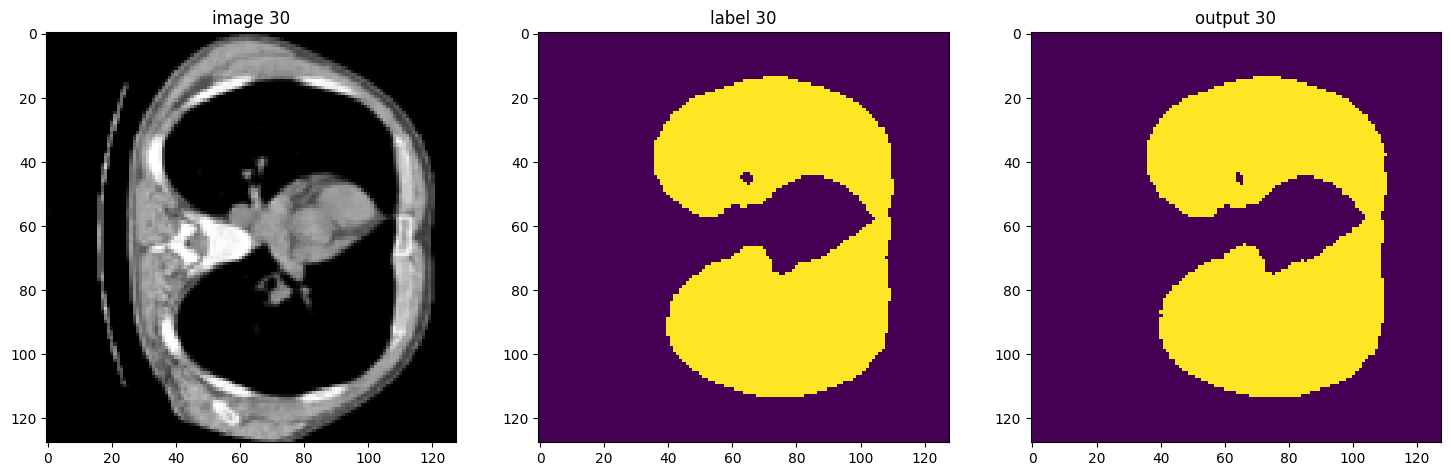

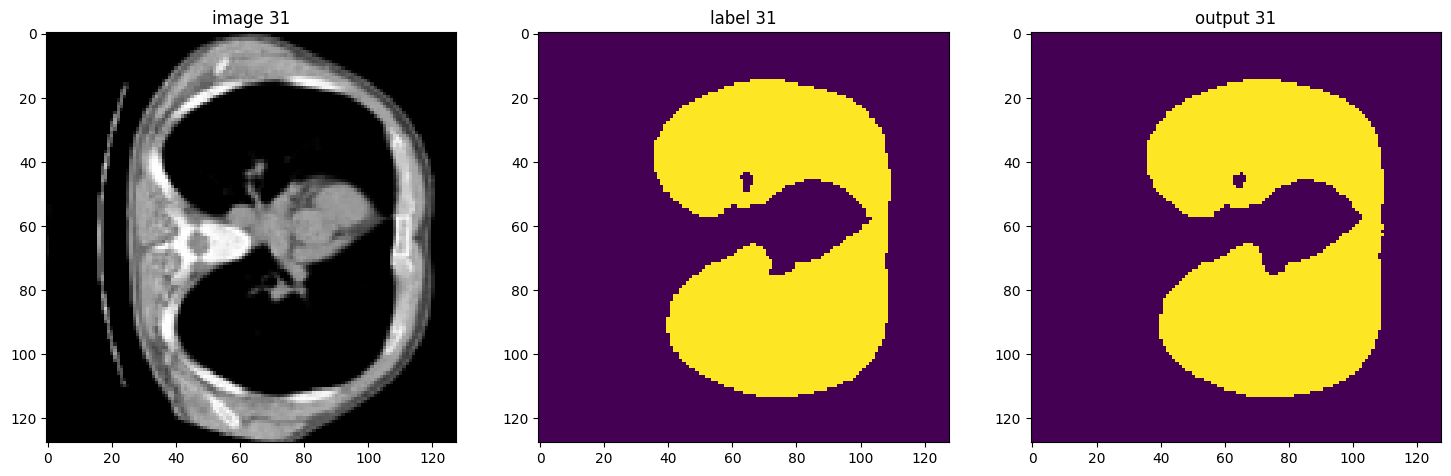

In [66]:
from monai.inferers import sliding_window_inference
from monai.transforms import Activations


sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53

    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()